In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
import requests
from bs4 import BeautifulSoup
import re
import math
import time

O que fazer:
* pega a data de lançamento de musicas no spotify, fazer isso em duas partes
* ver a duração das musicas de milisegundos para minutos, e ver se tem ouliers
* ver a relação das features com o engajamento

# Entrada de dados

In [2]:
spotify_youtube_pt1 = pd.read_csv("Dados/spotify_youtube_up_pt1.csv")
spotify_youtube_pt2 = pd.read_csv("Dados/spotify_youtube_up_pt2.csv")

In [3]:
data_extracao = pd.to_datetime("2023-02-07")
spotify_youtube_pt1["upload_date"] = pd.to_datetime(spotify_youtube_pt1["upload_date"])
spotify_youtube_pt1["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt1["upload_date"]).dt.days

spotify_youtube_pt2["upload_date"] = pd.to_datetime(spotify_youtube_pt2["upload_date"])
spotify_youtube_pt2["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt2["upload_date"]).dt.days

In [4]:
spotify_youtube = pd.concat([spotify_youtube_pt1,spotify_youtube_pt2])

In [5]:
spotify_youtube.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15610 entries, 0 to 7789
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          15610 non-null  int64         
 1   Artist              15610 non-null  object        
 2   Url_spotify         15610 non-null  object        
 3   Track               15610 non-null  object        
 4   Album               15610 non-null  object        
 5   Album_type          15610 non-null  object        
 6   Uri                 15610 non-null  object        
 7   Danceability        15609 non-null  float64       
 8   Energy              15609 non-null  float64       
 9   Key                 15609 non-null  float64       
 10  Loudness            15609 non-null  float64       
 11  Speechiness         15609 non-null  float64       
 12  Acousticness        15609 non-null  float64       
 13  Instrumentalness    15609 non-null  float64       
 

In [6]:
spotify_youtube.columns

Index(['Unnamed: 0', 'Artist', 'Url_spotify', 'Track', 'Album', 'Album_type',
       'Uri', 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Url_youtube', 'Title', 'Channel', 'Views', 'Likes',
       'Comments', 'Description', 'Licensed', 'official_video', 'Stream',
       'upload_date', 'dias_na_plataforma'],
      dtype='object')

In [7]:
print(f'numeros de musicas com 30 dias ou menos de existencia: {len(spotify_youtube[spotify_youtube['dias_na_plataforma']<31])}')
print(f'numeros de musicas com 90 dias ou menos de existencia: {len(spotify_youtube[spotify_youtube['dias_na_plataforma']<91])}')
print(f'numeros de musicas com 365 dias ou menos de existencia: {len(spotify_youtube[spotify_youtube['dias_na_plataforma']<365])}')

numeros de musicas com 30 dias ou menos de existencia: 322
numeros de musicas com 90 dias ou menos de existencia: 1107
numeros de musicas com 365 dias ou menos de existencia: 3379


In [8]:
youtube_df=spotify_youtube[['Artist','Track','Album','Album_type','Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness','Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo','Duration_ms','Url_youtube', 'Title', 'Channel', 'Views', 'Likes','Comments', 'Description','upload_date', 'dias_na_plataforma']]
youtube_df=youtube_df.reset_index()

In [9]:
youtube_df['engagement_rate'] = youtube_df.apply(lambda row: (row['Likes'] + row['Comments']) / row['Views'] * 100 if row['Views'] > 0 else 0, axis=1)

In [10]:
youtube_df=youtube_df[youtube_df['dias_na_plataforma']!=15]

In [11]:
youtube_df["Duration_min"] = youtube_df["Duration_ms"] / 60000

In [12]:
youtube_30_df=youtube_df[youtube_df['dias_na_plataforma']<31]
youtube_90_df=youtube_df[youtube_df['dias_na_plataforma']<91]
youtube_365_df=youtube_df[youtube_df['dias_na_plataforma']<366]

# Um mes


Valores maximo e minimo encontrados no intervalo de tempo:
* Valor maximo de engajamento:  15.15768056968464
* Valor minimo de engajamento:  0.18847291523499357
    
Numero de amostras:  322

Com excessão dos 4 primeriros dias do mes e o dia 16, se tem amostras de diferentes musicas que combrem um mes por completo

Possiveis abordadgens:
* Fazer um previsor pontual de engajamento de musica.
* Fazer um simulador de engajamento de musica no mes, prevendo o engajamento da musica para todos os dias do mes.

In [13]:
youtube_30_df.head(3)

index     Artist                                  Track  \
33      33  Metallica                      Screaming Suicide   
105    105       P!nk                              TRUSTFALL   
136    136    Shakira  Shakira: Bzrp Music Sessions, Vol. 53   

                                     Album Album_type  Danceability  Energy  \
33                       Screaming Suicide     single         0.425   0.972   
105                              TRUSTFALL     single         0.636   0.888   
136  Shakira: Bzrp Music Sessions, Vol. 53     single         0.778   0.632   

     Key  Loudness  Speechiness  ...  \
33   4.0    -3.448       0.0450  ...   
105  8.0    -3.889       0.0945  ...   
136  2.0    -5.600       0.0493  ...   

                                                 Title    Channel  \
33   Metallica: Screaming Suicide (Official Music V...  Metallica   
105                  P!NK - TRUSTFALL (Official Video)   PinkVEVO   
136                 SHAKIRA || BZRP Music Sessions #53   Bizarrap   

           Views      Likes  Comments  \
33     4317758.0   217109.0   17225.0   
105    3309247.0   146755.0    5707.0   
136  252068988.0  9415668.0  525670.0   

                                           Description         upload_date  \
33   Metallica's official music video for “Screamin... 2023-01-19 23:00:19   
105  P!NK's new album "TRUSTFALL" is available Febr... 2023-01-27 14:00:11   
136  SHAKIRA || BZRP Music Sessions #53\n\nLyrics b... 2023-01-12 00:00:07   

    dias_na_plataforma engagement_rate  Duration_min  
33                  18        5.427215      5.507550  
105                 10        4.607151      3.953333  
136                 25        3.943896      3.638150  

[3 rows x 27 columns]

In [14]:
set(youtube_30_df.Album_type)

{'album', 'single'}

In [15]:
len(set(youtube_30_df.Artist))

247

In [16]:
youtube_30_df['artist_number'] = youtube_30_df['Artist'].str.split(',').str.len()

C:\Users\Samsung\AppData\Local\Temp\ipykernel_30592\2593099650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_30_df['artist_number'] = youtube_30_df['Artist'].str.split(',').str.len()


In [17]:
columns_drop=['index', 'Artist', 'Track', 'Album','Url_youtube', 'Title', 'Channel']
youtube_30_df=youtube_30_df.drop(columns=columns_drop)

In [18]:
print("Valor maximo de engajamento: ",youtube_30_df.engagement_rate.max())
print("Valor minimo de engajamento: ",youtube_30_df.engagement_rate.min())
print("Numero de amostras: ",len(youtube_30_df))

Valor maximo de engajamento:  12.721906475609487
Valor minimo de engajamento:  0.18847291523499357
Numero de amostras:  321


In [19]:
youtube_30_df["class_egagement_rate"] = youtube_30_df["engagement_rate"].apply(lambda x: 1 if x >= 3 else 0)

In [20]:
# Let's identify the columns with a value between 0-1.
columns_to_check = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 
                    'Instrumentalness', 'Liveness', 'Valence']

# Checking values outside the 0-1 range and printing.
for col in columns_to_check:
    out_of_range = youtube_30_df[(youtube_30_df[col] < 0) | (youtube_30_df[col] > 1)]
    print(f"In the {col} column, {len(out_of_range)} values were found outside the 0-1 range.")
    if not out_of_range.empty:
        print(out_of_range[[col]])
    print('-' * 74)

In the Danceability column, 0 values were found outside the 0-1 range.
--------------------------------------------------------------------------
In the Energy column, 0 values were found outside the 0-1 range.
--------------------------------------------------------------------------
In the Speechiness column, 0 values were found outside the 0-1 range.
--------------------------------------------------------------------------
In the Acousticness column, 0 values were found outside the 0-1 range.
--------------------------------------------------------------------------
In the Instrumentalness column, 0 values were found outside the 0-1 range.
--------------------------------------------------------------------------
In the Liveness column, 0 values were found outside the 0-1 range.
--------------------------------------------------------------------------
In the Valence column, 0 values were found outside the 0-1 range.
-----------------------------------------------------------------

## Graficos

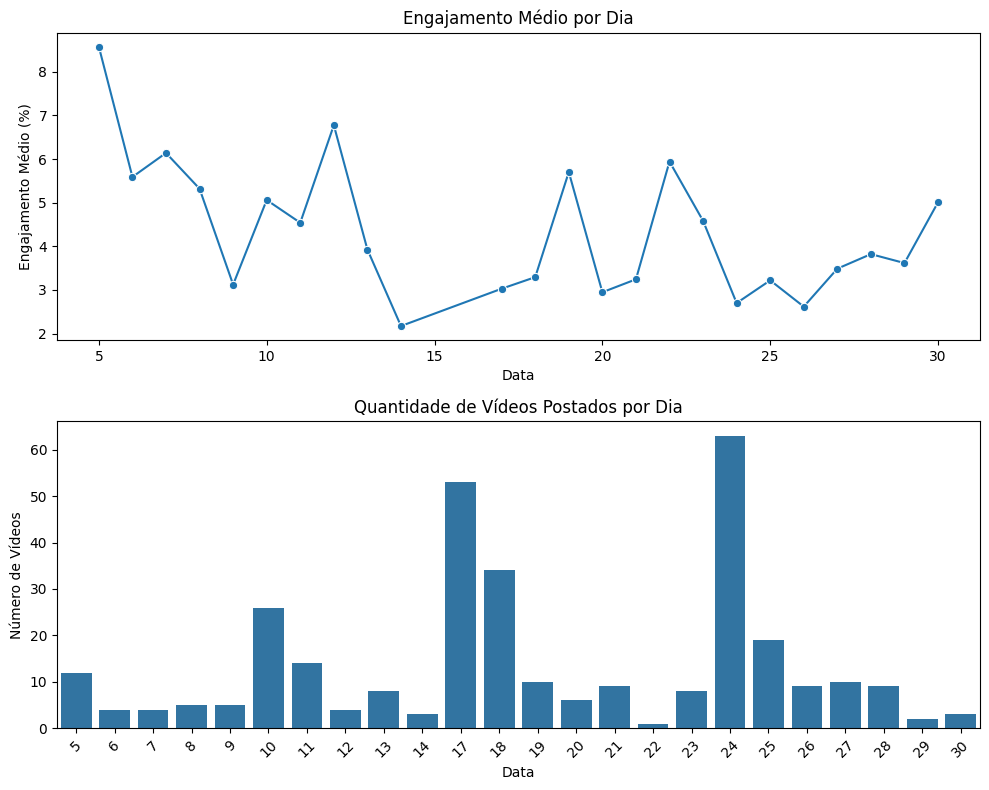

In [21]:
df_grouped = youtube_30_df.groupby('dias_na_plataforma').agg(
    engagement_mean=('engagement_rate', 'mean'), 
    video_count=('Views', 'count')  # Contando vídeos por dia
).reset_index()
fig, ax1 = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico 1: Engajamento médio por dia
sns.lineplot(data=df_grouped, x='dias_na_plataforma', y='engagement_mean', marker='o', ax=ax1[0])
ax1[0].set_title('Engajamento Médio por Dia')
ax1[0].set_ylabel('Engajamento Médio (%)')
ax1[0].set_xlabel('Data')

# Gráfico 2: Quantidade de vídeos por dia
sns.barplot(data=df_grouped, x='dias_na_plataforma', y='video_count', ax=ax1[1])
ax1[1].set_title('Quantidade de Vídeos Postados por Dia')
ax1[1].set_ylabel('Número de Vídeos')
ax1[1].set_xlabel('Data')

# Ajustar layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

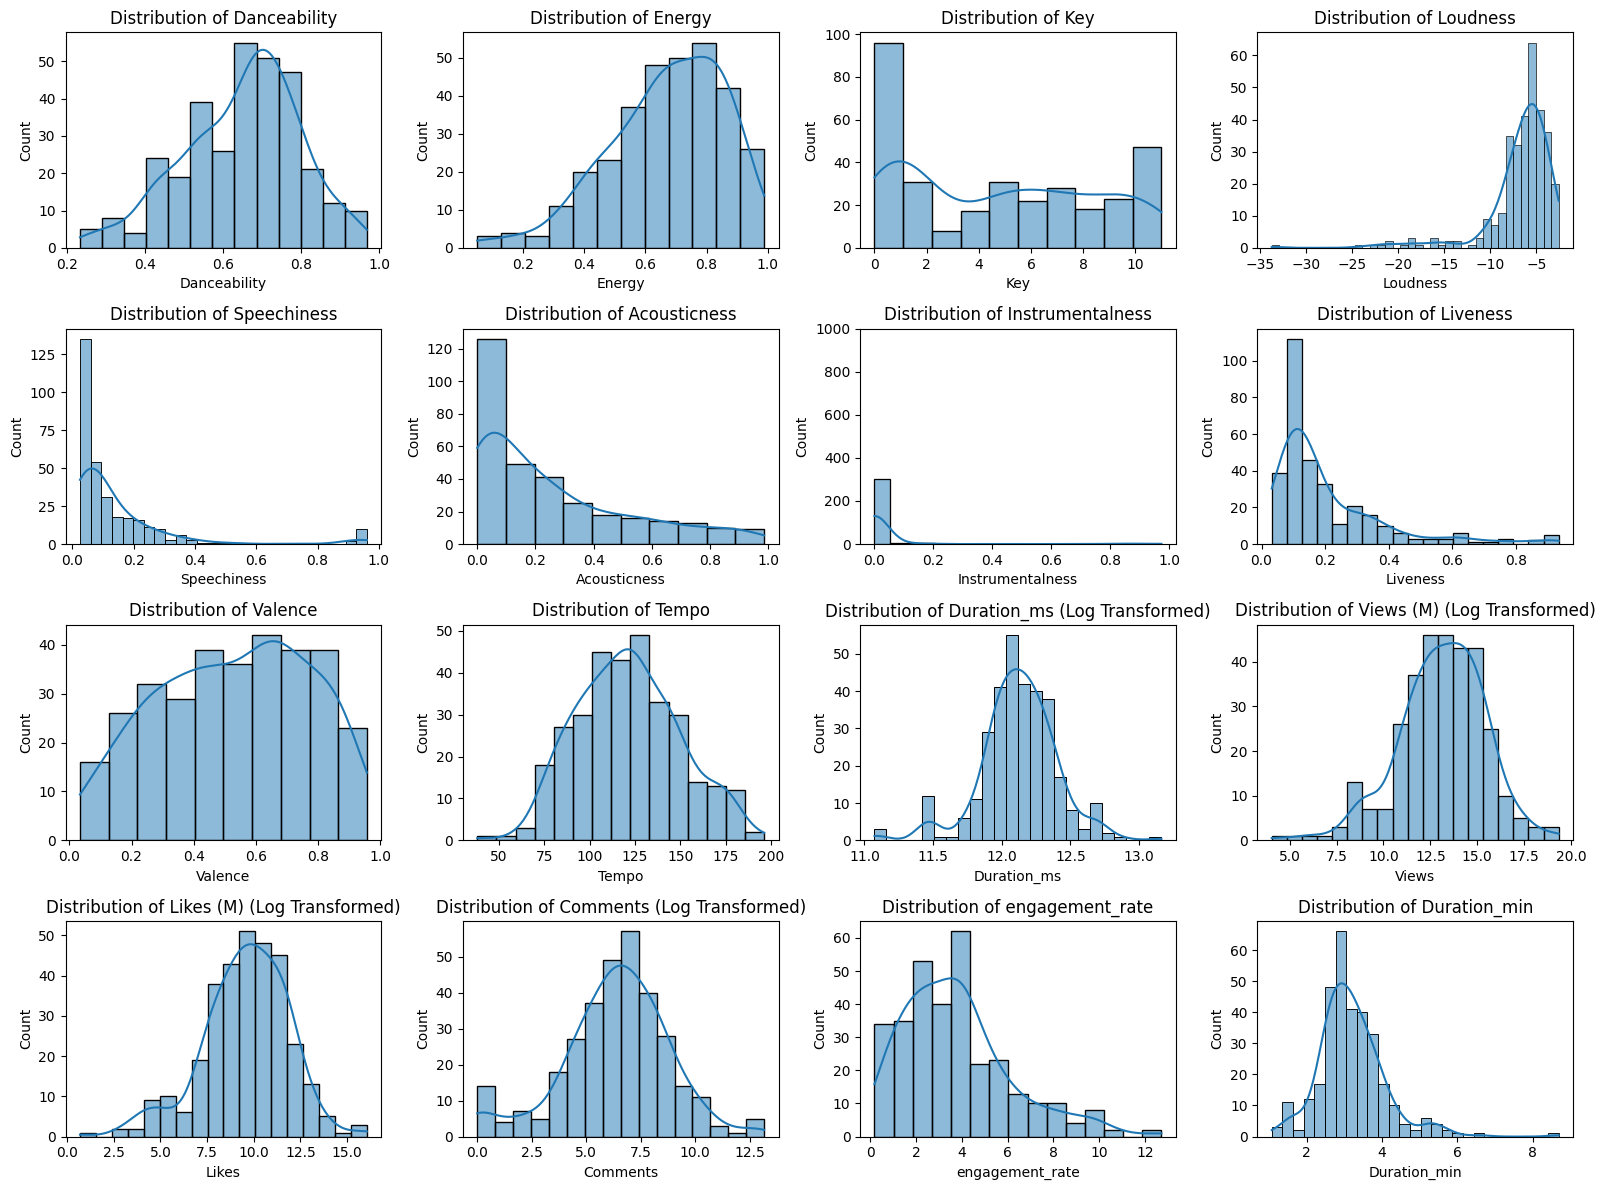

In [22]:
def get_scale_title(col_data, col_name):
    max_val = col_data.max()
    if max_val >= 1e9:
        scale = " (B)"
    elif max_val >= 1e6:
        scale = " (M)"
    else:
        scale = ""
    return f"{col_name}{scale}"

df_numeric = youtube_30_df.select_dtypes(include = ["float64"])


df_log = df_numeric.apply(lambda x: np.log1p(x) if x.max() > 1e5 else x)


plt.figure(figsize = (16, 12))
for i, col in enumerate(df_log, 1):
    plt.subplot(4, 4, i)
    
    
    if col == "Instrumentalness":
        sns.histplot(youtube_30_df[col], kde = True, binwidth = 0.05)
        plt.ylim(0, 1000)
    else:
        sns.histplot(df_log[col], kde = True)
    
    
    title = get_scale_title(df_numeric[col], col)
    plt.title(f"Distribution of {title} (Log Transformed)" if df_numeric[col].max() > 1e5 else f"Distribution of {col}")
    plt.xlabel(col)
    
plt.tight_layout()
plt.show()

Total number of outliers in column Duration_min: 18
Lower limit: 1.202308333333333, Upper limit: 5.0717083333333335
-----------------------------------------------------------
Total number of outliers in column Likes: 30
Lower limit: -101682.25, Upper limit: 178923.75
-----------------------------------------------------------
Total number of outliers in column Views: 38
Lower limit: -3213631.5, Upper limit: 5719396.5
-----------------------------------------------------------
Total number of outliers in column Tempo: 1
Lower limit: 43.80549999999999, Upper limit: 197.77750000000003
-----------------------------------------------------------
Total number of outliers in column Comments: 37
Lower limit: -3804.25, Upper limit: 6779.75
-----------------------------------------------------------
Total number of outliers in column engagement_rate: 13
Lower limit: -2.3271980727811155, Upper limit: 9.293701251305336
-----------------------------------------------------------


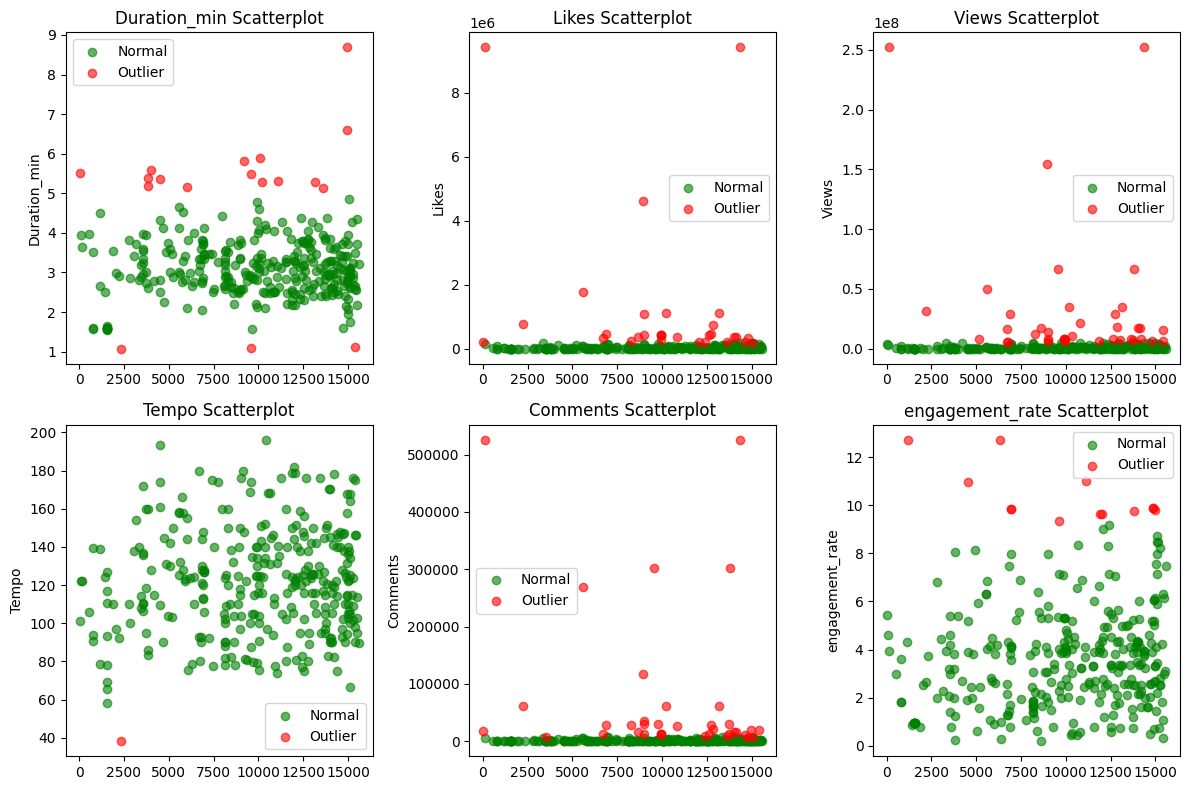

In [23]:

def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


columns_to_check = ["Duration_min", "Likes", "Views", "Tempo","Comments","engagement_rate"]


plt.figure(figsize = (12, 8))
for i, col in enumerate(columns_to_check, 1):

    outliers, lower, upper = find_outliers_iqr(youtube_30_df, col)

   
    normal_values = youtube_30_df[(youtube_30_df[col] >= lower) & (youtube_30_df[col] <= upper)]

    
    plt.subplot(2, 3, i)
    plt.scatter(normal_values.index, normal_values[col], label = "Normal", alpha = 0.6, c = "green")
    plt.scatter(outliers.index, outliers[col], label = "Outlier", alpha=0.6, c = "red")
    plt.title(f"{col} Scatterplot")
    plt.ylabel(col)
    plt.legend()

    
    print(f"Total number of outliers in column {col}: {len(outliers)}")
    print(f"Lower limit: {lower}, Upper limit: {upper}")
    print("-" * 59)

plt.tight_layout()
plt.show()

C:\Users\Samsung\AppData\Local\Temp\ipykernel_30592\3982807462.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  youtube_30_df.groupby("Energy_group")["Views"].sum().plot(kind = "bar", color = "midnightblue")
C:\Users\Samsung\AppData\Local\Temp\ipykernel_30592\3982807462.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  youtube_30_df.groupby("Valence_group")["Views"].sum().plot(kind = "bar", color = "maroon")
C:\Users\Samsung\AppData\Local\Temp\ipykernel_30592\3982807462.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obse

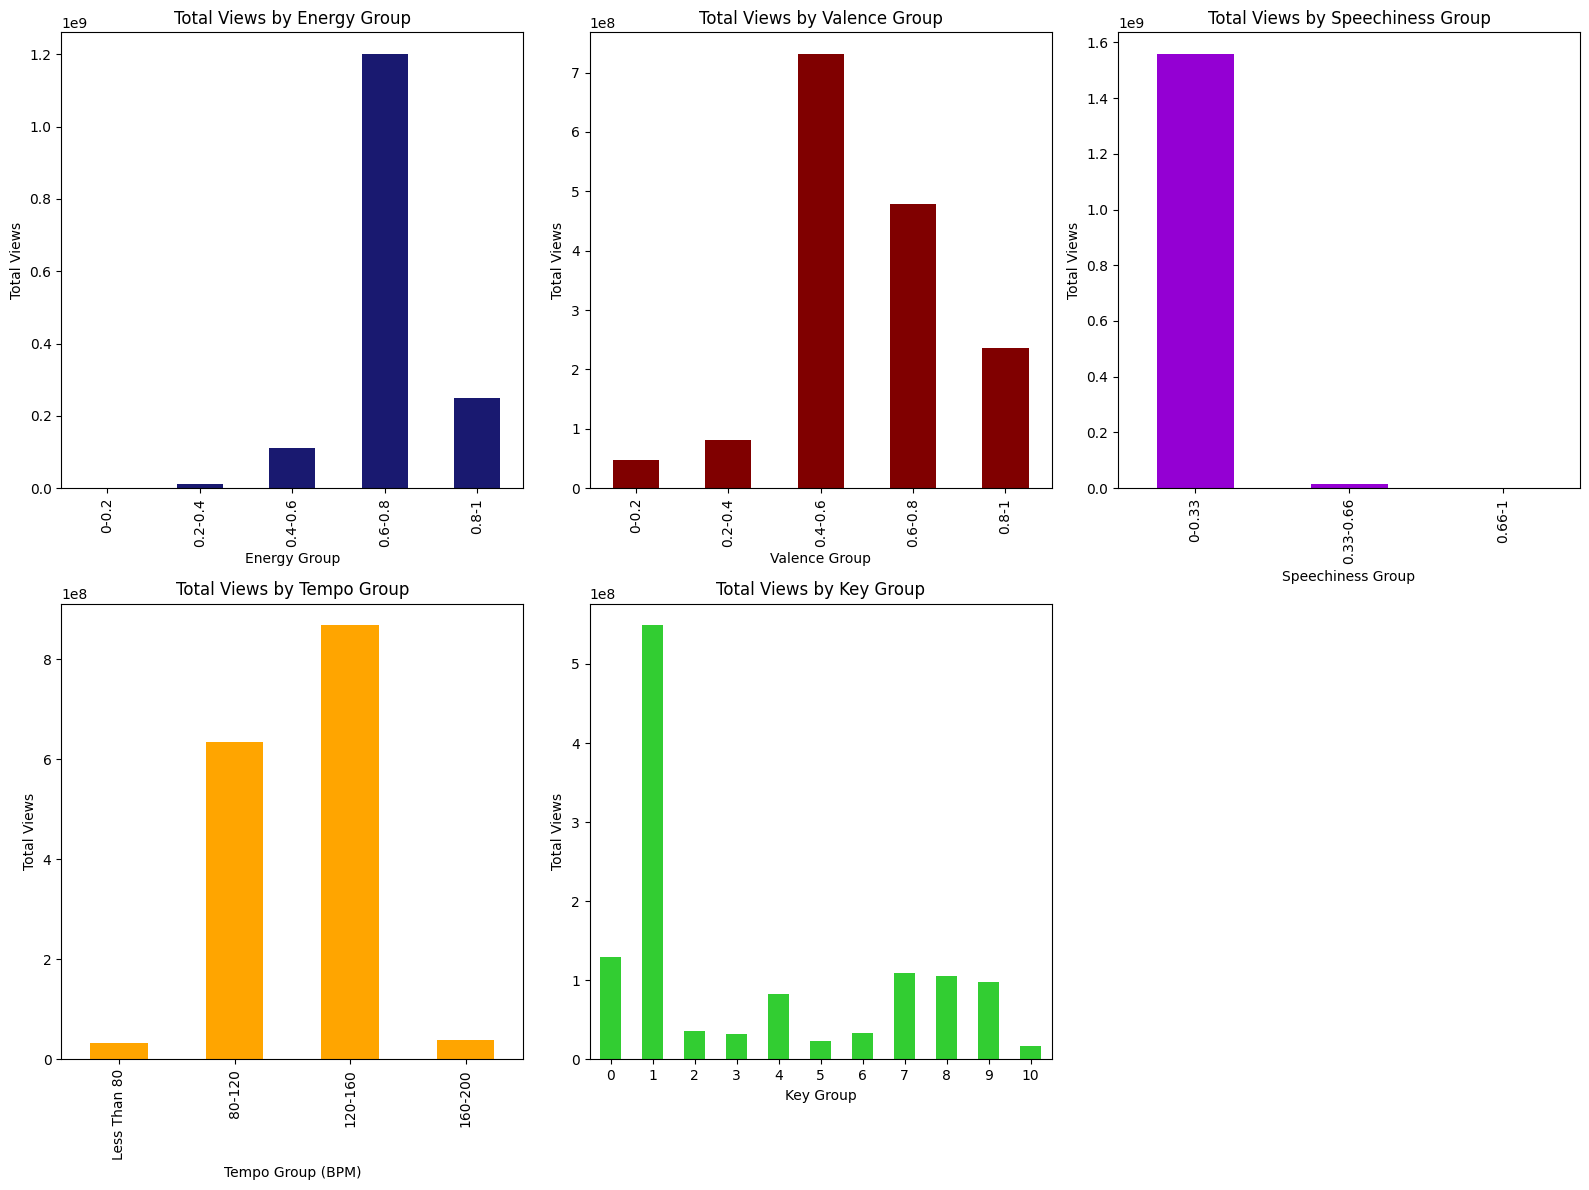

In [24]:
energy_bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
valence_bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
speechiness_bins = [0, 0.33, 0.66, 1]
tempo_bins = [0, 80, 120, 160, 200]

# Grouping the features into bins
youtube_30_df["Energy_group"] = pd.cut(youtube_30_df["Energy"], bins = energy_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"])
youtube_30_df["Valence_group"] = pd.cut(youtube_30_df["Valence"], bins = valence_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"])
youtube_30_df["Speechiness_group"] = pd.cut(youtube_30_df["Speechiness"], bins = speechiness_bins, labels = ["0-0.33", "0.33-0.66", "0.66-1"])
youtube_30_df["Tempo_group"] = pd.cut(youtube_30_df["Tempo"], bins = tempo_bins, labels = ["Less Than 80", "80-120", "120-160", "160-200"])
youtube_30_df["Key_group"] = pd.cut(youtube_30_df["Key"], bins = range(0, 12), labels = [f"{i}" for i in range(11)])

# Now that we have done the grouping, let's start visualization
plt.figure(figsize = (16, 12))

# Energy
plt.subplot(2, 3, 1)
youtube_30_df.groupby("Energy_group")["Views"].sum().plot(kind = "bar", color = "midnightblue")
plt.title("Total Views by Energy Group")
plt.xlabel("Energy Group")
plt.ylabel("Total Views")

# Valence
plt.subplot(2, 3, 2)
youtube_30_df.groupby("Valence_group")["Views"].sum().plot(kind = "bar", color = "maroon")
plt.title("Total Views by Valence Group")
plt.xlabel("Valence Group")
plt.ylabel("Total Views")

# Speechiness
plt.subplot(2, 3, 3)
youtube_30_df.groupby("Speechiness_group")["Views"].sum().plot(kind = "bar", color = "darkviolet")
plt.title("Total Views by Speechiness Group")
plt.xlabel("Speechiness Group")
plt.ylabel("Total Views")

# Tempo
plt.subplot(2, 3, 4)
youtube_30_df.groupby("Tempo_group")["Views"].sum().plot(kind = "bar", color = "orange")
plt.title("Total Views by Tempo Group")
plt.xlabel("Tempo Group (BPM)")
plt.ylabel("Total Views")

# Key
plt.subplot(2, 3, 5)
youtube_30_df.groupby("Key_group")["Views"].sum().plot(kind = "bar", color = "limegreen")
plt.title("Total Views by Key Group")
plt.xlabel("Key Group")
plt.ylabel("Total Views")
plt.xticks(rotation = 0)

plt.tight_layout()
plt.show()

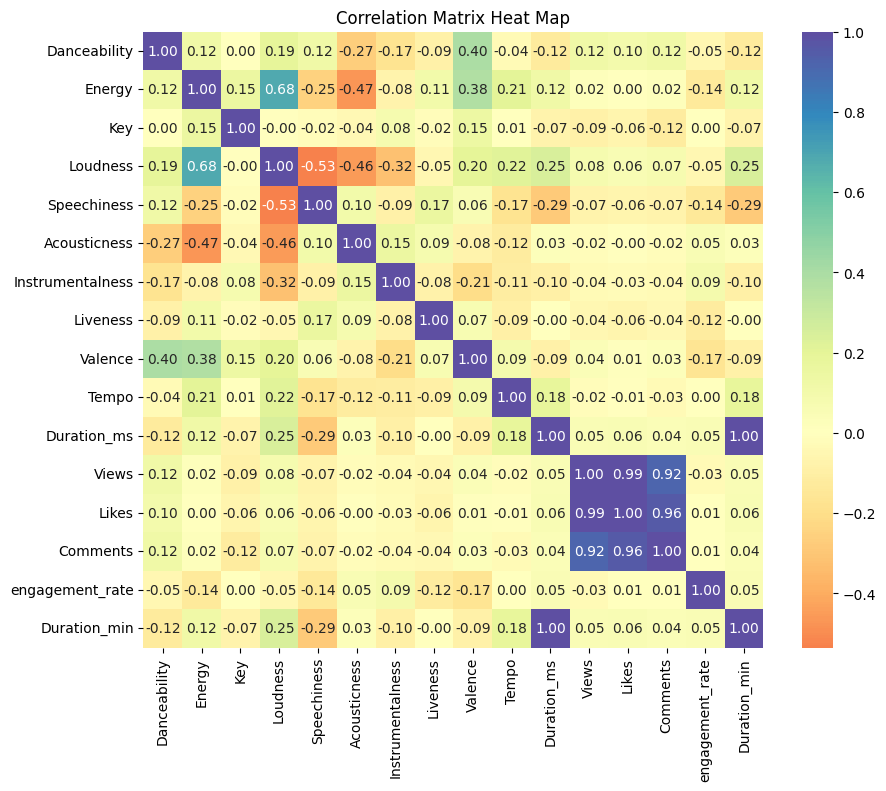

In [25]:
corr_matrix = df_numeric.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = "Spectral", center = 0, fmt = ".2f")
plt.title("Correlation Matrix Heat Map")
plt.show()

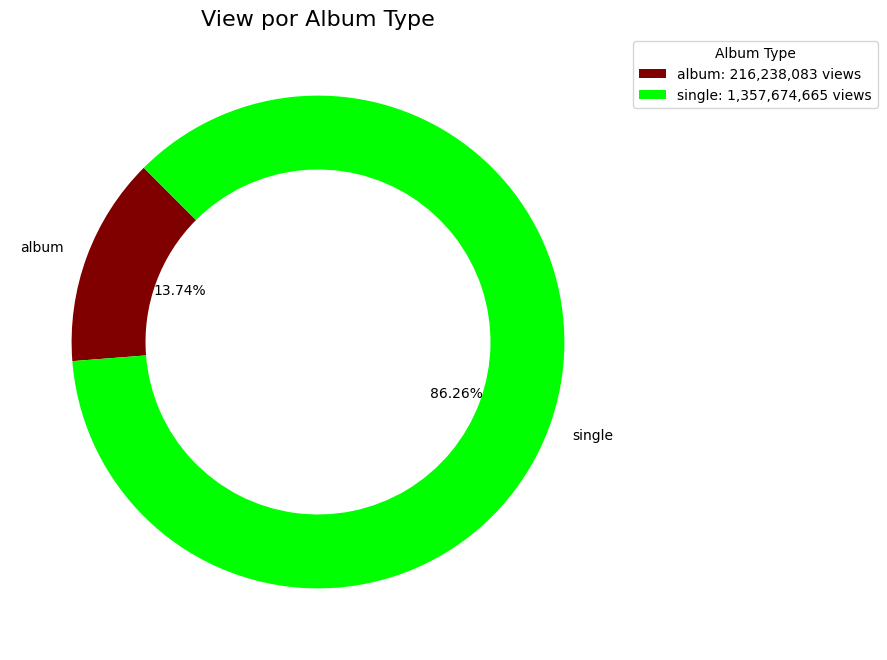

In [26]:
album_views = youtube_30_df.groupby("Album_type")["Views"].sum()

# Now let's create the Donut Chart.
plt.figure(figsize = (8, 8))

plt.pie(album_views, labels = album_views.index, autopct = "%1.2f%%", startangle = 135, colors = ["maroon", "lime", "navy"], wedgeprops = dict(width = 0.3))
plt.title("View por Album Type", fontsize = 16)
plt.legend(labels = [f"{label}: {value:,.0f} views" for label, value in zip(album_views.index, album_views)],
           title = "Album Type", loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1))

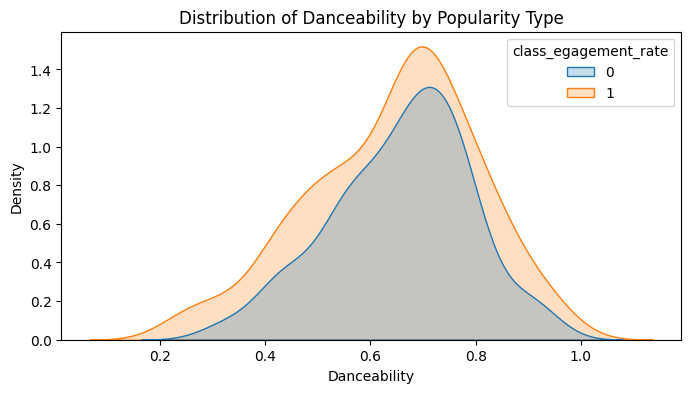

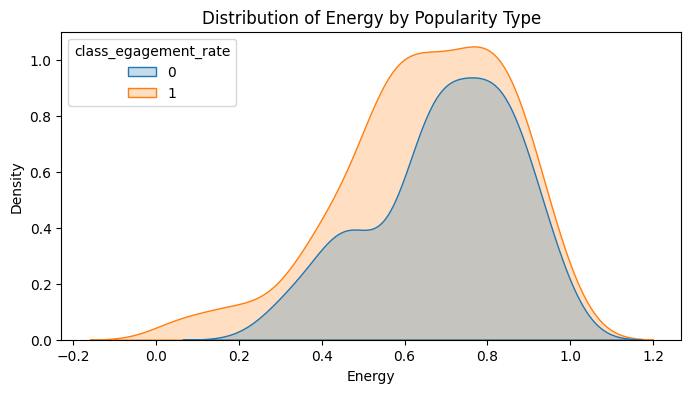

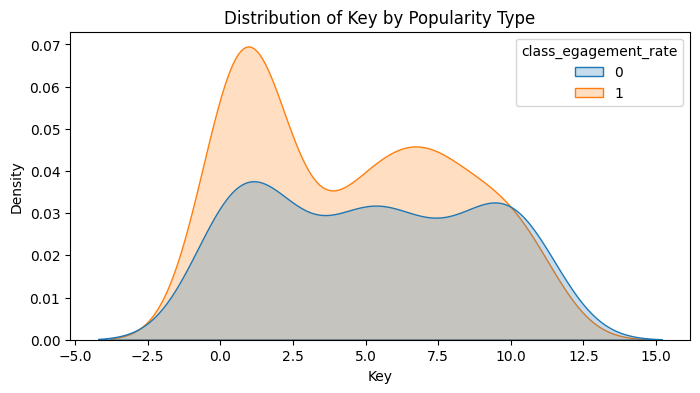

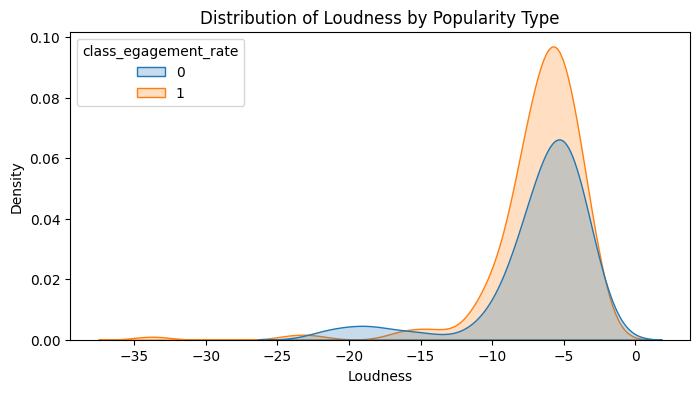

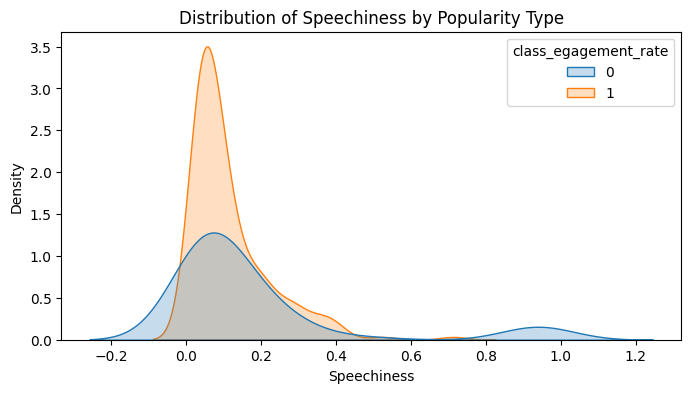

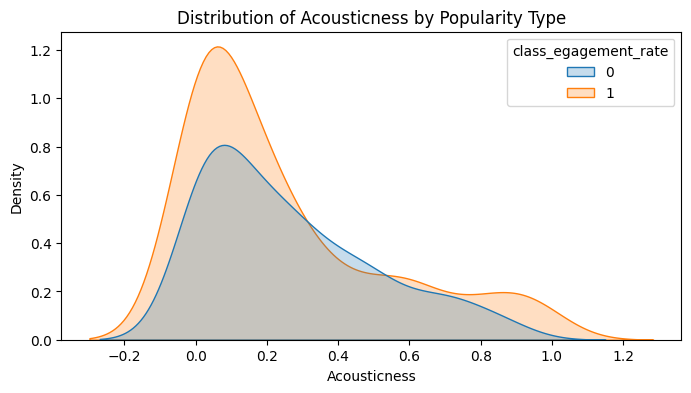

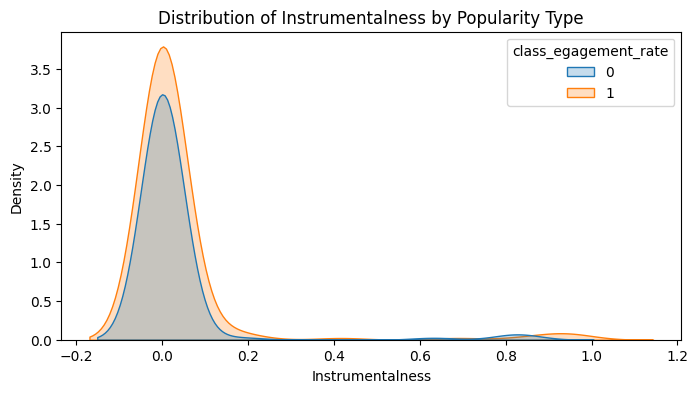

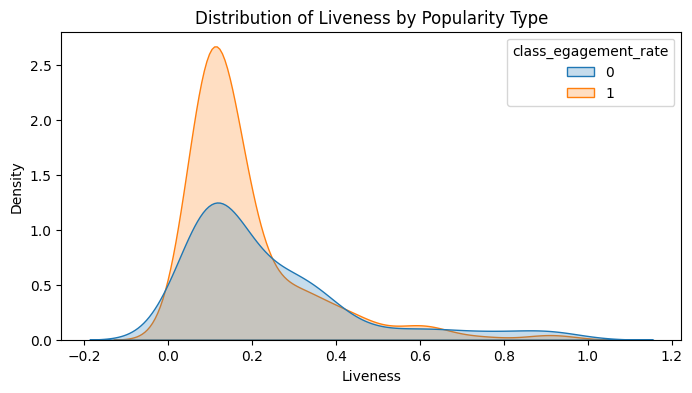

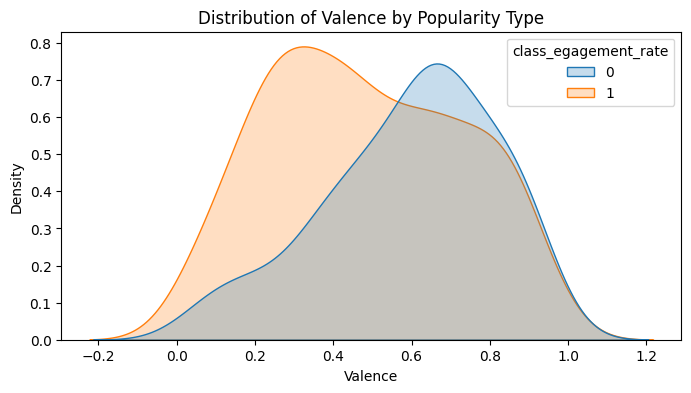

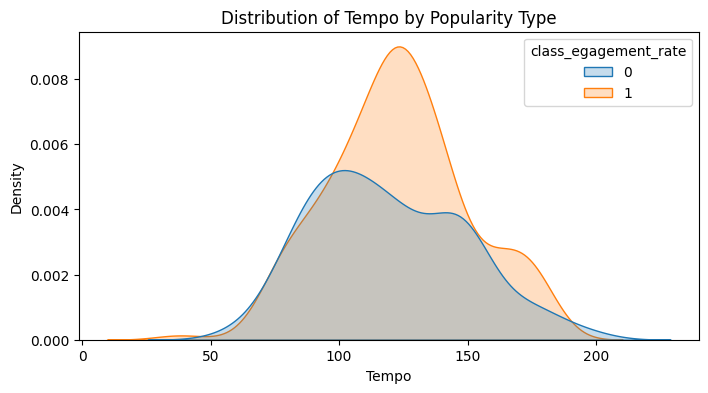

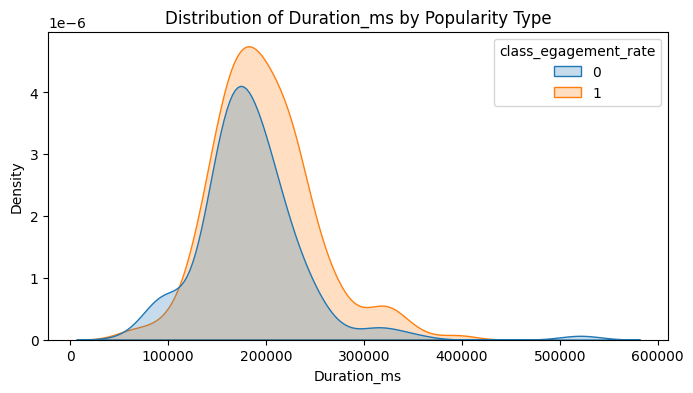

In [27]:
audio_features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness','Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo','Duration_ms']
for feature in audio_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=youtube_30_df, x=feature, hue='class_egagement_rate', fill=True)
    plt.title(f'Distribution of {feature} by Popularity Type')
    plt.show()

## Limpeza do df

In [27]:
youtube_30_df = pd.get_dummies(youtube_30_df, columns=["Album_type"], dtype=int)

In [29]:
youtube_30_df['artist_number'] = youtube_30_df['Artist'].str.split(',').str.len()

In [ ]:
columns_drop=['index', 'Artist', 'Track', 'Album','Url_youtube', 'Title', 'Channel','Description', 'upload_date','Duration_min','Views', 'Likes', 'Comments']
youtube_30_clean=youtube_30_df.drop(columns=columns_drop)


In [ ]:
col = 'engagement_rate'  
youtube_30_clean = youtube_30_clean[[c for c in youtube_30_clean if c != col] + [col]]

In [42]:
youtube_30_clean.to_csv("Youtube_30_df.csv", index=False)  


# Tres meses

Valores maximo e minimo encontrados no intervalo de tempo:
* Valor maximo de engajamento:  17.467501964589104
* Valor minimo de engajamento:  0.0
    
Numero de amostras:  1107

In [13]:
youtube_90_df.head(3)

index     Artist                                              Track  \
6       6   Gorillaz  New Gold (feat. Tame Impala and Bootie Brown) ...   
31     31  Metallica                                         Lux Æterna   
33     33  Metallica                                  Screaming Suicide   

                                                Album Album_type  \
6   New Gold (feat. Tame Impala and Bootie Brown) ...     single   
31                                         Lux Æterna     single   
33                                  Screaming Suicide     single   

    Danceability  Energy   Key  Loudness  Speechiness  ...  \
6          0.716   0.897   4.0    -7.185       0.0629  ...   
31         0.386   0.996  11.0    -2.960       0.0754  ...   
33         0.425   0.972   4.0    -3.448       0.0450  ...   

                                                Title    Channel       Views  \
6   Gorillaz - New Gold ft. Tame Impala, Bootie Br...  Dom Dolla    451996.0   
31       Metallica: Lux Æterna (Official Music Video)  Metallica  14937918.0   
33  Metallica: Screaming Suicide (Official Music V...  Metallica   4317758.0   

       Likes  Comments                                        Description  \
6    11686.0     241.0  Gorillaz 'New Gold' ft. Tame Impala, Bootie Br...   
31  473751.0   46230.0  Metallica's official music video for “Lux Æter...   
33  217109.0   17225.0  Metallica's official music video for “Screamin...   

           upload_date dias_na_plataforma engagement_rate  Duration_min  
6  2022-11-18 20:30:00                 80        2.638740      4.569033  
31 2022-11-28 15:00:20                 70        3.480947      3.428000  
33 2023-01-19 23:00:19                 18        5.427215      5.507550  

[3 rows x 27 columns]

In [14]:
print("Valor maximo de engajamento: ",youtube_90_df.engagement_rate.max())
print("Valor minimo de engajamento: ",youtube_90_df.engagement_rate.min())
print("Numero de amostras: ",len(youtube_90_df))

Valor maximo de engajamento:  17.467501964589104
Valor minimo de engajamento:  0.0
Numero de amostras:  1106


In [15]:
youtube_90_df["class_egagement_rate"] = youtube_90_df["engagement_rate"].apply(lambda x: 1 if x >= 3 else 0)

C:\Users\Samsung\AppData\Local\Temp\ipykernel_12700\1927064356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_90_df["class_egagement_rate"] = youtube_90_df["engagement_rate"].apply(lambda x: 1 if x >= 3 else 0)


## Graficos

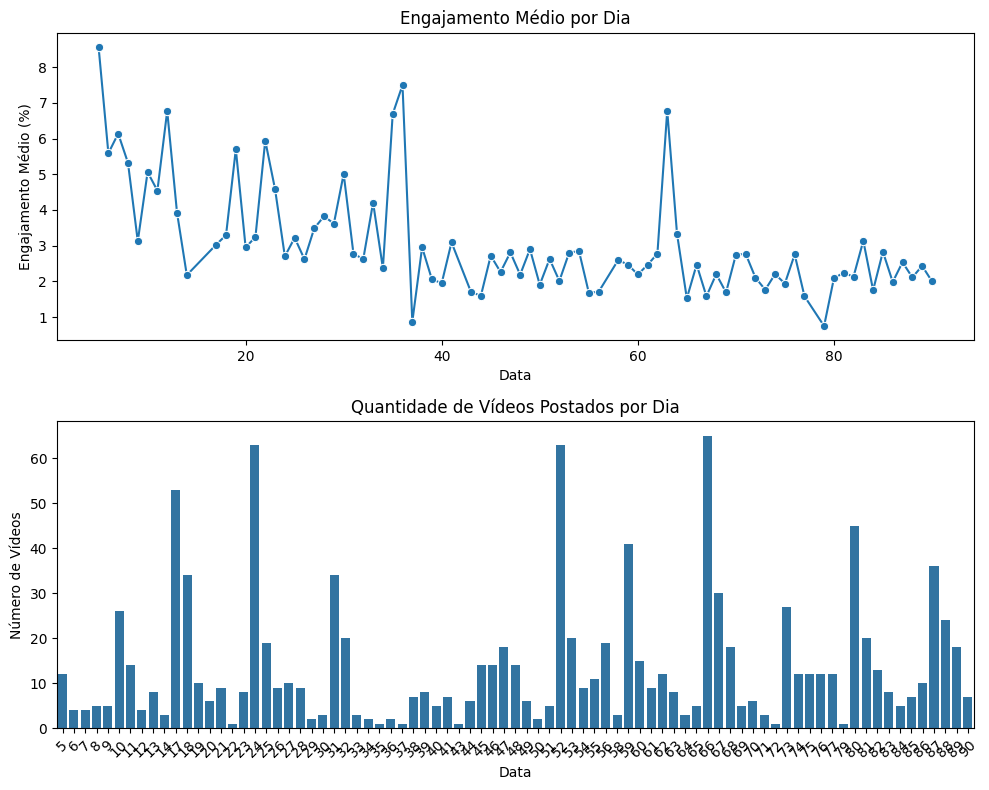

In [16]:
df_grouped = youtube_90_df.groupby('dias_na_plataforma').agg(
    engagement_mean=('engagement_rate', 'mean'), 
    video_count=('Views', 'count')  # Contando vídeos por dia
).reset_index()
fig, ax1 = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico 1: Engajamento médio por dia
sns.lineplot(data=df_grouped, x='dias_na_plataforma', y='engagement_mean', marker='o', ax=ax1[0])
ax1[0].set_title('Engajamento Médio por Dia')
ax1[0].set_ylabel('Engajamento Médio (%)')
ax1[0].set_xlabel('Data')

# Gráfico 2: Quantidade de vídeos por dia
sns.barplot(data=df_grouped, x='dias_na_plataforma', y='video_count', ax=ax1[1])
ax1[1].set_title('Quantidade de Vídeos Postados por Dia')
ax1[1].set_ylabel('Número de Vídeos')
ax1[1].set_xlabel('Data')

# Ajustar layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

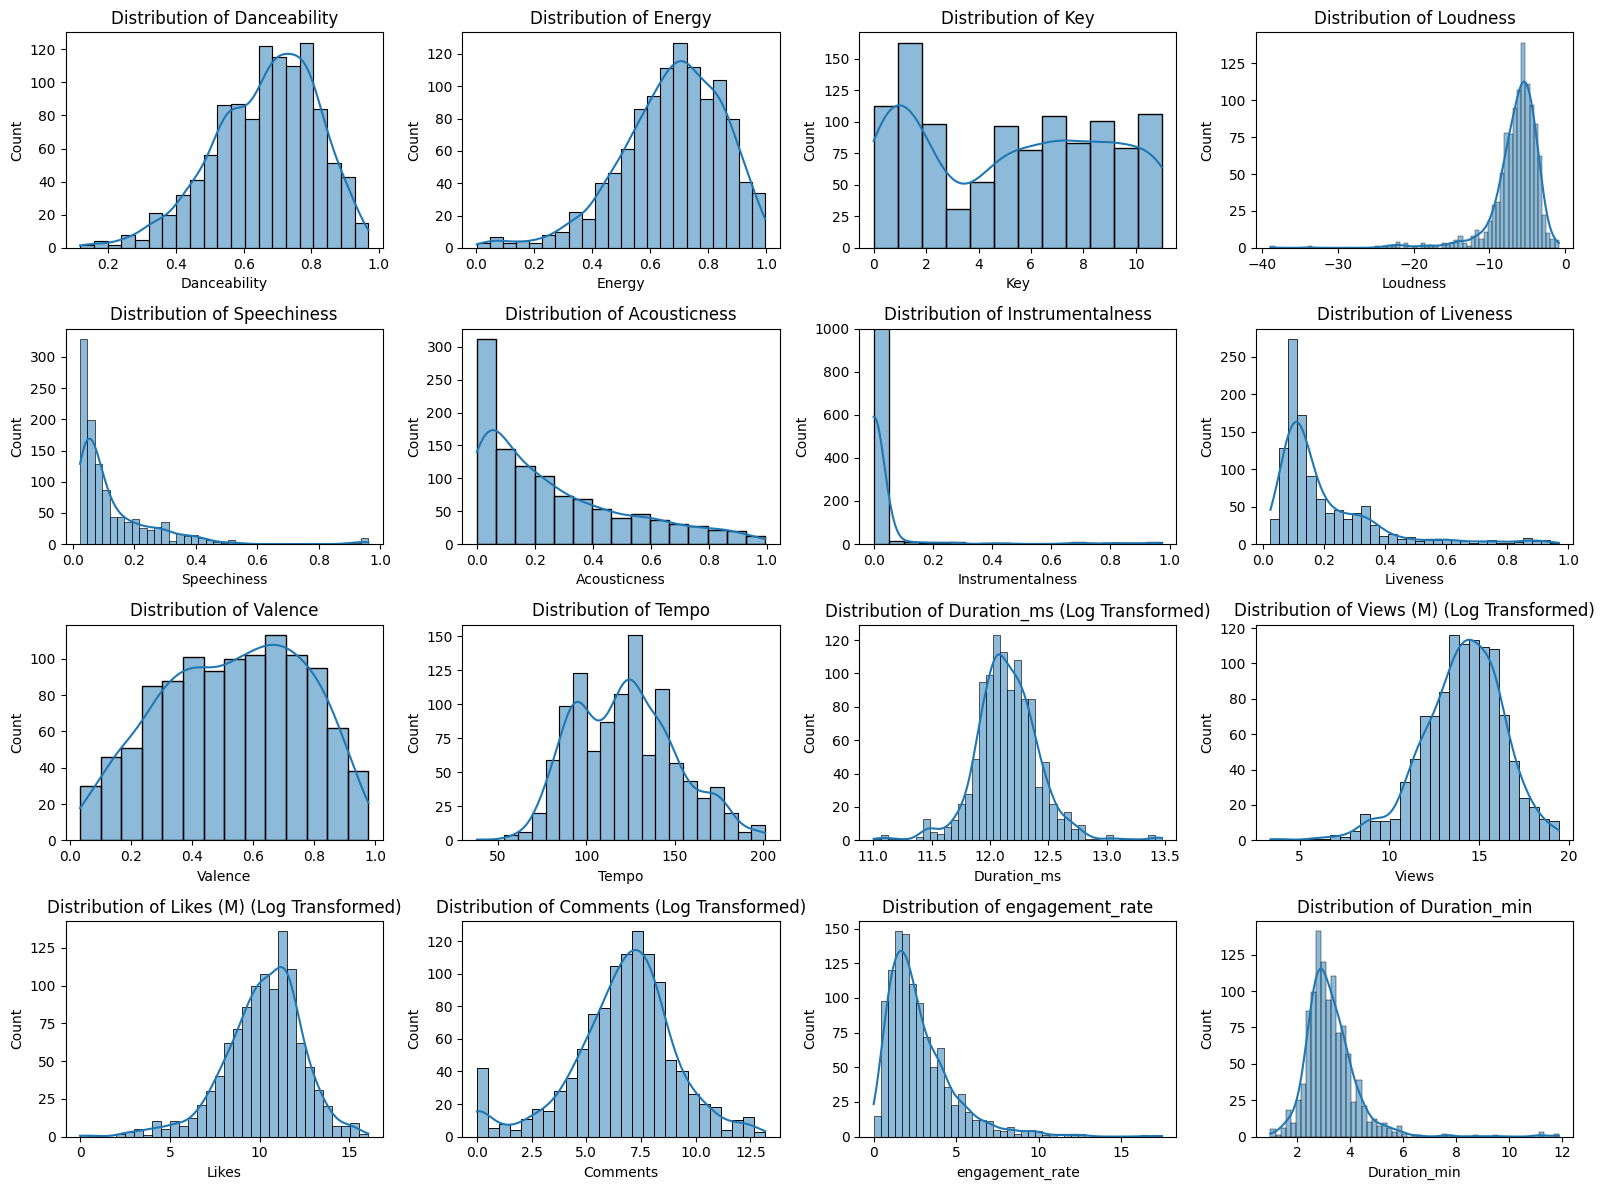

In [17]:
def get_scale_title(col_data, col_name):
    max_val = col_data.max()
    if max_val >= 1e9:
        scale = " (B)"
    elif max_val >= 1e6:
        scale = " (M)"
    else:
        scale = ""
    return f"{col_name}{scale}"

df_numeric = youtube_90_df.select_dtypes(include = ["float64"])


df_log = df_numeric.apply(lambda x: np.log1p(x) if x.max() > 1e5 else x)


plt.figure(figsize = (16, 12))
for i, col in enumerate(df_log, 1):
    plt.subplot(4, 4, i)
    
    
    if col == "Instrumentalness":
        sns.histplot(youtube_90_df[col], kde = True, binwidth = 0.05)
        plt.ylim(0, 1000)
    else:
        sns.histplot(df_log[col], kde = True)
    
    
    title = get_scale_title(df_numeric[col], col)
    plt.title(f"Distribution of {title} (Log Transformed)" if df_numeric[col].max() > 1e5 else f"Distribution of {col}")
    plt.xlabel(col)
    
plt.tight_layout()
plt.show()

Total number of outliers in column Duration_min: 45
Lower limit: 1.2084812500000006, Upper limit: 5.189931249999999
-----------------------------------------------------------
Total number of outliers in column Likes: 128
Lower limit: -146667.125, Upper limit: 266581.875
-----------------------------------------------------------
Total number of outliers in column Views: 127
Lower limit: -8646577.75, Upper limit: 15328300.25
-----------------------------------------------------------
Total number of outliers in column Tempo: 0
Lower limit: 34.89237499999997, Upper limit: 203.12537500000002
-----------------------------------------------------------
Total number of outliers in column Comments: 146
Lower limit: -4352.0, Upper limit: 7880.0
-----------------------------------------------------------
Total number of outliers in column engagement_rate: 48
Lower limit: -1.9683483922812917, Upper limit: 6.989668238534673
-----------------------------------------------------------


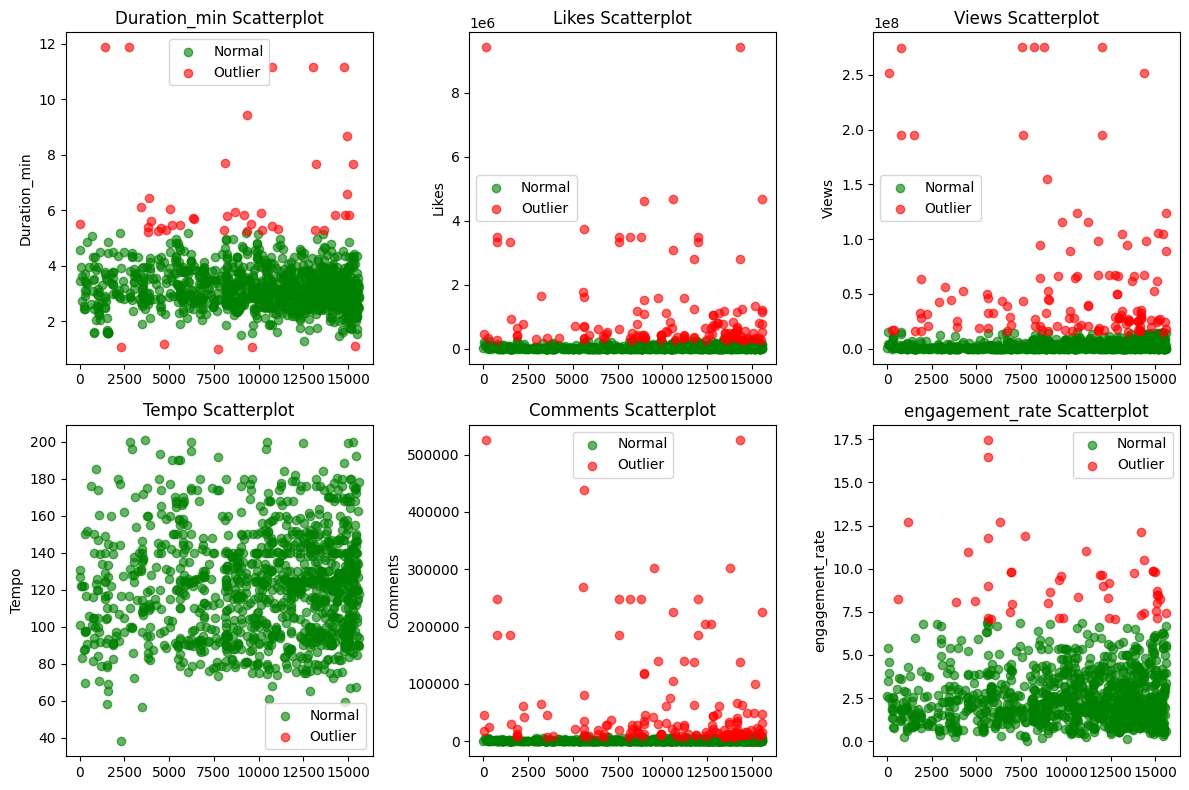

In [18]:

def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


columns_to_check = ["Duration_min", "Likes", "Views", "Tempo","Comments","engagement_rate"]


plt.figure(figsize = (12, 8))
for i, col in enumerate(columns_to_check, 1):

    outliers, lower, upper = find_outliers_iqr(youtube_90_df, col)

   
    normal_values = youtube_90_df[(youtube_90_df[col] >= lower) & (youtube_90_df[col] <= upper)]

    
    plt.subplot(2, 3, i)
    plt.scatter(normal_values.index, normal_values[col], label = "Normal", alpha = 0.6, c = "green")
    plt.scatter(outliers.index, outliers[col], label = "Outlier", alpha=0.6, c = "red")
    plt.title(f"{col} Scatterplot")
    plt.ylabel(col)
    plt.legend()

    
    print(f"Total number of outliers in column {col}: {len(outliers)}")
    print(f"Lower limit: {lower}, Upper limit: {upper}")
    print("-" * 59)

plt.tight_layout()
plt.show()

C:\Users\Samsung\AppData\Local\Temp\ipykernel_12700\1860724993.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_90_df["Energy_group"] = pd.cut(youtube_90_df["Energy"], bins = energy_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"])
C:\Users\Samsung\AppData\Local\Temp\ipykernel_12700\1860724993.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_90_df["Valence_group"] = pd.cut(youtube_90_df["Valence"], bins = valence_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8

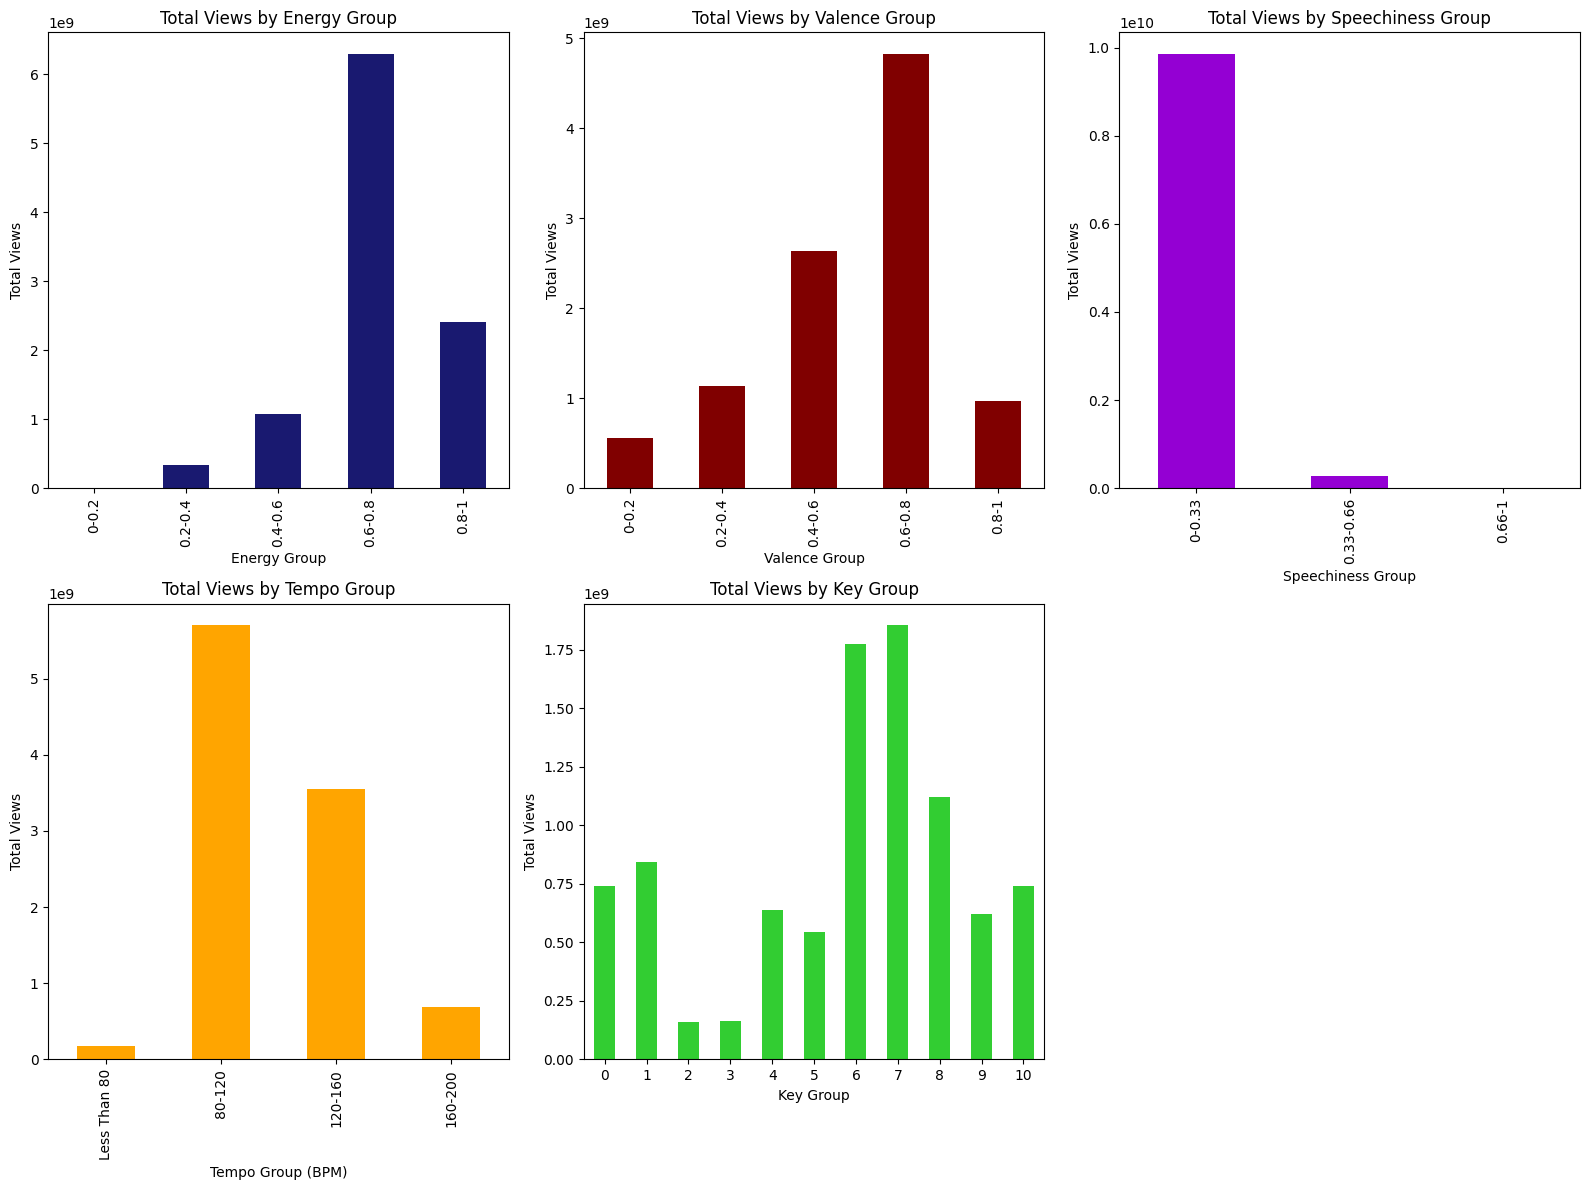

In [19]:
energy_bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
valence_bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
speechiness_bins = [0, 0.33, 0.66, 1]
tempo_bins = [0, 80, 120, 160, 200]

# Grouping the features into bins
youtube_90_df["Energy_group"] = pd.cut(youtube_90_df["Energy"], bins = energy_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"])
youtube_90_df["Valence_group"] = pd.cut(youtube_90_df["Valence"], bins = valence_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"])
youtube_90_df["Speechiness_group"] = pd.cut(youtube_90_df["Speechiness"], bins = speechiness_bins, labels = ["0-0.33", "0.33-0.66", "0.66-1"])
youtube_90_df["Tempo_group"] = pd.cut(youtube_90_df["Tempo"], bins = tempo_bins, labels = ["Less Than 80", "80-120", "120-160", "160-200"])
youtube_90_df["Key_group"] = pd.cut(youtube_90_df["Key"], bins = range(0, 12), labels = [f"{i}" for i in range(11)])

# Now that we have done the grouping, let's start visualization
plt.figure(figsize = (16, 12))

# Energy
plt.subplot(2, 3, 1)
youtube_90_df.groupby("Energy_group")["Views"].sum().plot(kind = "bar", color = "midnightblue")
plt.title("Total Views by Energy Group")
plt.xlabel("Energy Group")
plt.ylabel("Total Views")

# Valence
plt.subplot(2, 3, 2)
youtube_90_df.groupby("Valence_group")["Views"].sum().plot(kind = "bar", color = "maroon")
plt.title("Total Views by Valence Group")
plt.xlabel("Valence Group")
plt.ylabel("Total Views")

# Speechiness
plt.subplot(2, 3, 3)
youtube_90_df.groupby("Speechiness_group")["Views"].sum().plot(kind = "bar", color = "darkviolet")
plt.title("Total Views by Speechiness Group")
plt.xlabel("Speechiness Group")
plt.ylabel("Total Views")

# Tempo
plt.subplot(2, 3, 4)
youtube_90_df.groupby("Tempo_group")["Views"].sum().plot(kind = "bar", color = "orange")
plt.title("Total Views by Tempo Group")
plt.xlabel("Tempo Group (BPM)")
plt.ylabel("Total Views")

# Key
plt.subplot(2, 3, 5)
youtube_90_df.groupby("Key_group")["Views"].sum().plot(kind = "bar", color = "limegreen")
plt.title("Total Views by Key Group")
plt.xlabel("Key Group")
plt.ylabel("Total Views")
plt.xticks(rotation = 0)

plt.tight_layout()
plt.show()

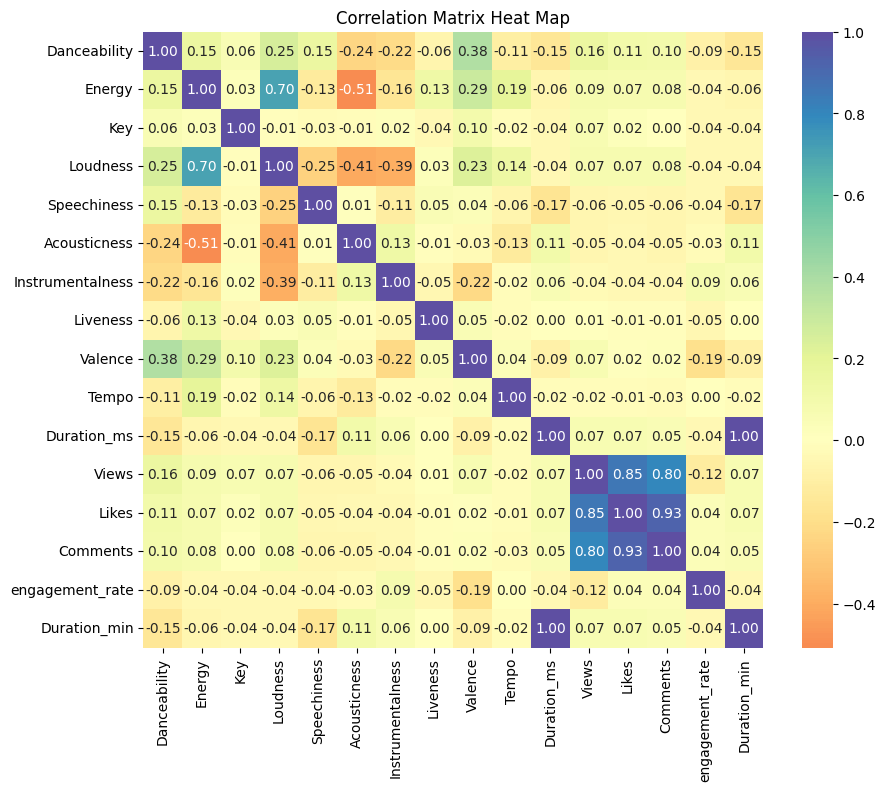

In [20]:
corr_matrix = df_numeric.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = "Spectral", center = 0, fmt = ".2f")
plt.title("Correlation Matrix Heat Map")
plt.show()

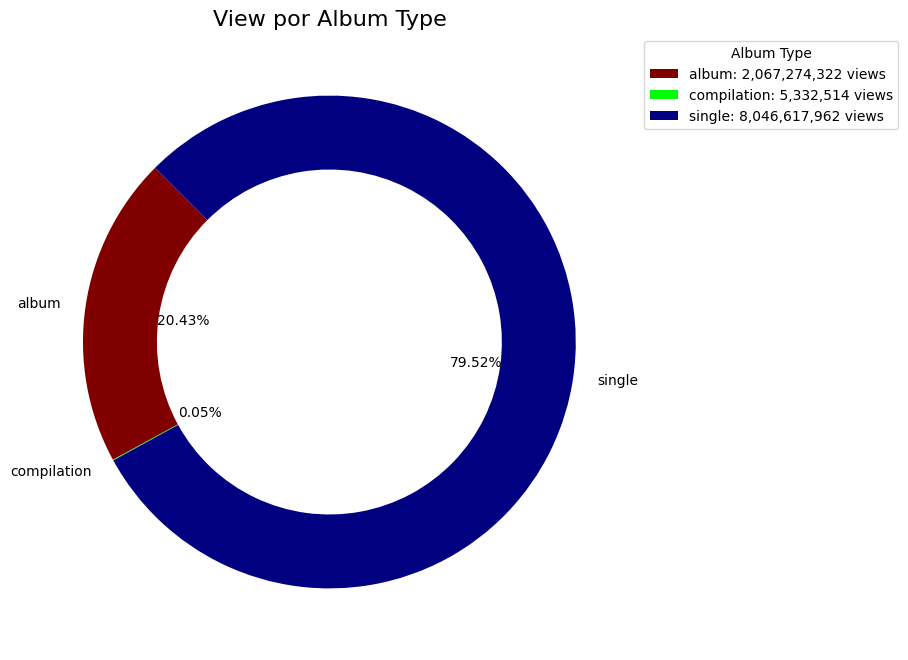

In [21]:
album_views = youtube_90_df.groupby("Album_type")["Views"].sum()

# Now let's create the Donut Chart.
plt.figure(figsize = (8, 8))

plt.pie(album_views, labels = album_views.index, autopct = "%1.2f%%", startangle = 135, colors = ["maroon", "lime", "navy"], wedgeprops = dict(width = 0.3))
plt.title("View por Album Type", fontsize = 16)
plt.legend(labels = [f"{label}: {value:,.0f} views" for label, value in zip(album_views.index, album_views)],
           title = "Album Type", loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1))

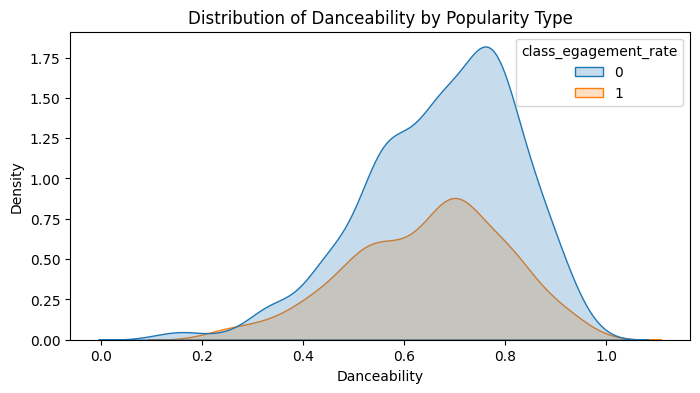

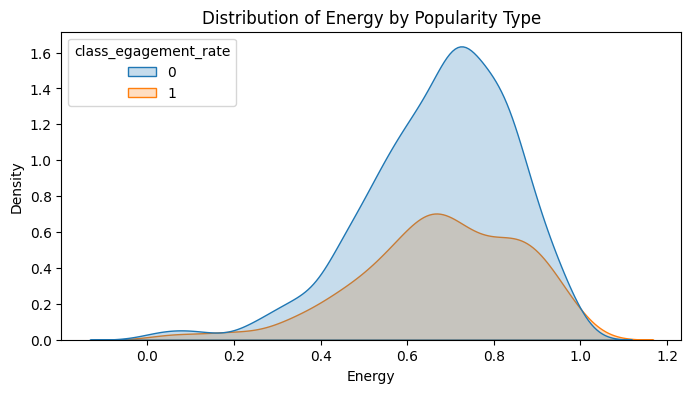

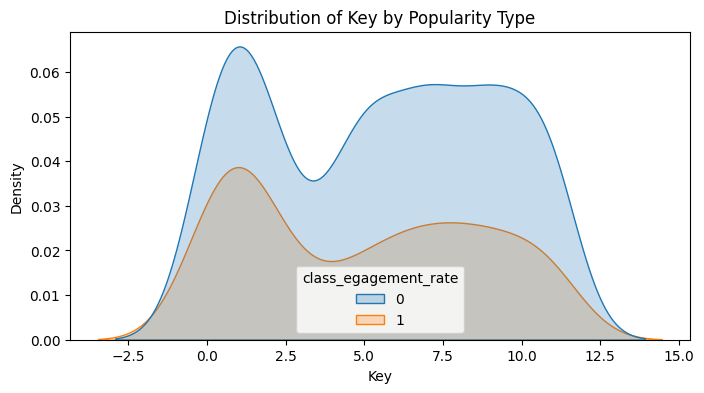

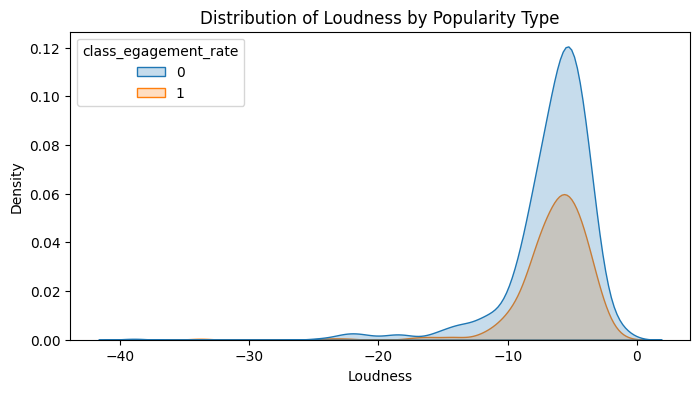

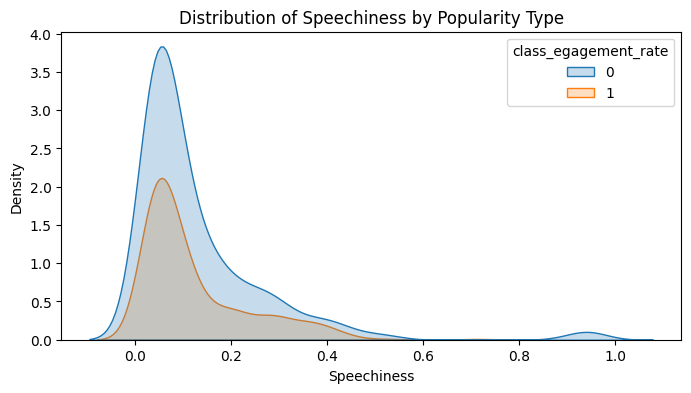

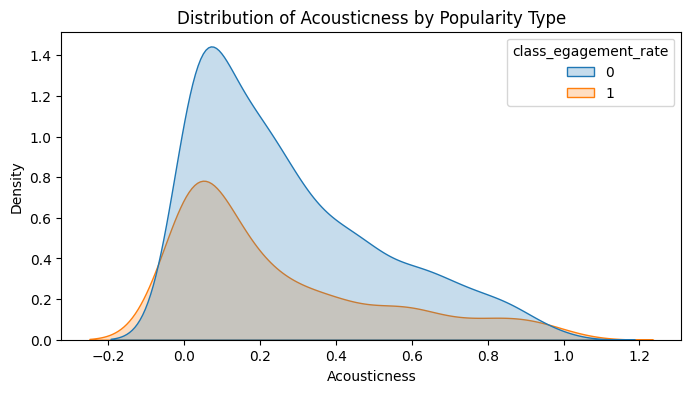

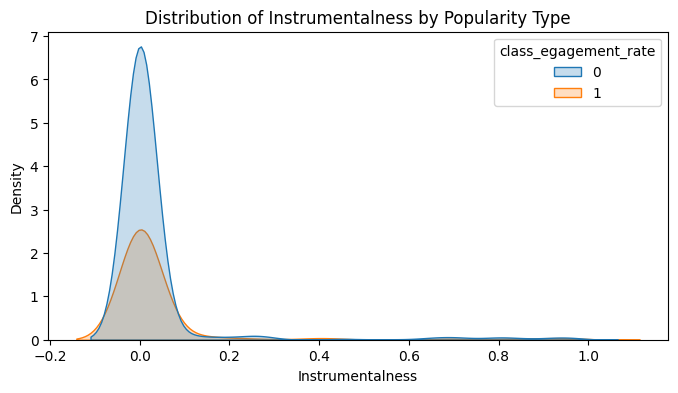

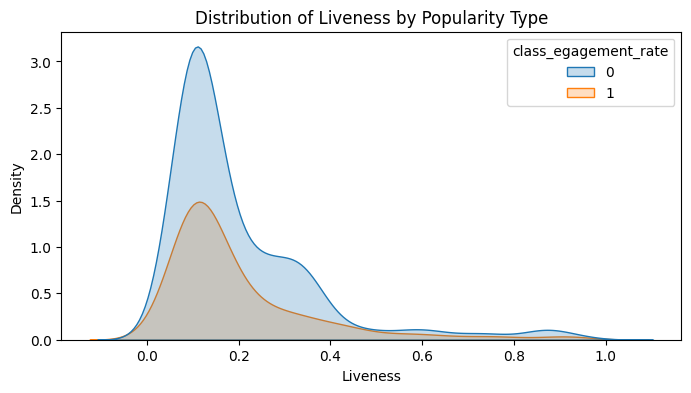

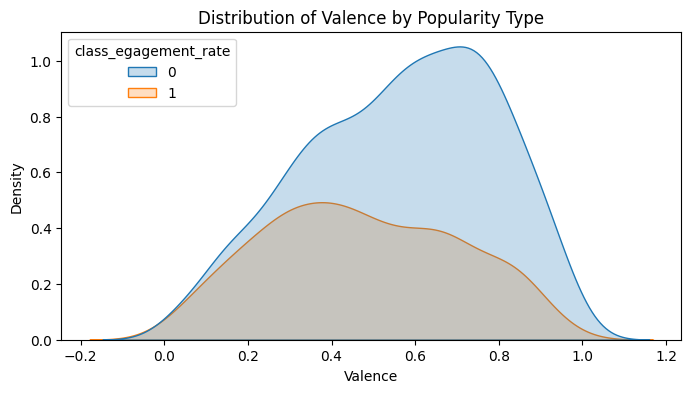

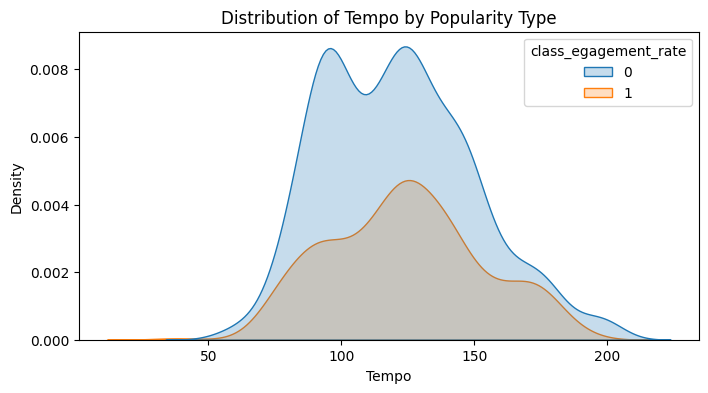

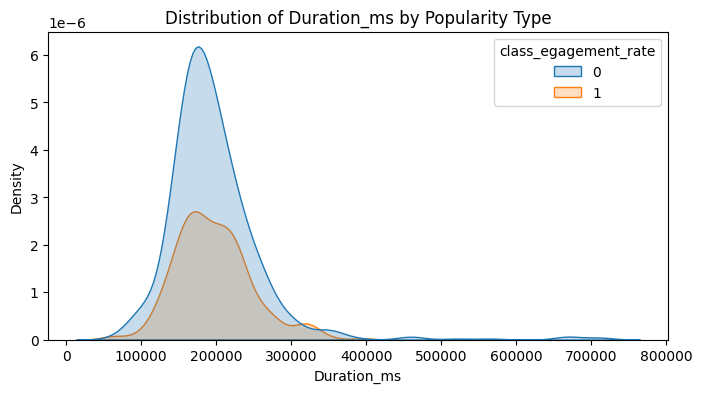

In [22]:
audio_features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness','Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo','Duration_ms']
for feature in audio_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=youtube_90_df, x=feature, hue='class_egagement_rate', fill=True)
    plt.title(f'Distribution of {feature} by Popularity Type')
    plt.show()

## Limpeza do df

In [43]:
youtube_90_df = pd.get_dummies(youtube_90_df, columns=["Album_type"], dtype=int)

In [44]:
youtube_90_df['artist_number'] = youtube_90_df['Artist'].str.split(',').str.len()

In [45]:
columns_drop=['index', 'Artist', 'Track', 'Album','Url_youtube', 'Title', 'Channel','Description', 'upload_date','Duration_min','Views', 'Likes', 'Comments']
youtube_90_clean=youtube_90_df.drop(columns=columns_drop)


In [46]:
col = 'engagement_rate'  
youtube_90_clean = youtube_90_clean[[c for c in youtube_90_clean if c != col] + [col]]

In [69]:
youtube_90_clean.to_csv("Youtube_90_df.csv", index=False)  


# Dose meses

Valores maximo e minimo encontrados no intervalo de tempo:
* Valor maximo de engajamento:  25.346066004877994
* Valor minimo de engajamento:  0.0
    
Numero de amostras:  3379

In [56]:
youtube_365_df.head(3)

index    Artist                                              Track  \
2      2  Gorillaz      New Gold (feat. Tame Impala and Bootie Brown)   
6      6  Gorillaz  New Gold (feat. Tame Impala and Bootie Brown) ...   
7      7  Gorillaz                  Cracker Island (feat. Thundercat)   

                                               Album Album_type  Danceability  \
2      New Gold (feat. Tame Impala and Bootie Brown)     single         0.695   
6  New Gold (feat. Tame Impala and Bootie Brown) ...     single         0.716   
7                  Cracker Island (feat. Thundercat)     single         0.741   

   Energy  Key  Loudness  Speechiness  ...  \
2   0.923  1.0    -3.930       0.0522  ...   
6   0.897  4.0    -7.185       0.0629  ...   
7   0.913  2.0    -3.340       0.0465  ...   

                                         Description         upload_date  \
2  Gorillaz - New Gold ft. Tame Impala & Bootie B... 2022-08-31 17:21:40   
6  Gorillaz 'New Gold' ft. Tame Impala, Bootie Br... 2022-11-18 20:30:00   
7  Listen to Cracker Island: https://gorillaz.lnk... 2022-07-28 16:00:11   

   dias_na_plataforma  engagement_rate  Duration_min  Energy_group  \
2                 159         3.432592      3.585833         0.8-1   
6                  80         2.638740      4.569033         0.8-1   
7                 193         3.106413      3.562500         0.8-1   

  Valence_group Speechiness_group Tempo_group  Key_group  
2       0.4-0.6            0-0.33      80-120          0  
6       0.2-0.4            0-0.33     120-160          3  
7       0.6-0.8            0-0.33     120-160          1  

[3 rows x 32 columns]

In [57]:
print("Valor maximo de engajamento: ",youtube_365_df.engagement_rate.max())
print("Valor minimo de engajamento: ",youtube_365_df.engagement_rate.min())
print("Numero de amostras: ",len(youtube_365_df))

Valor maximo de engajamento:  25.346066004877994
Valor minimo de engajamento:  0.0
Numero de amostras:  3378


In [58]:
youtube_365_df[youtube_365_df['engagement_rate']>=25]

index  Artist  Track            Album Album_type  Danceability  Energy  \
15021   7201  j-hope  Intro  Jack In The Box      album         0.607   0.355   

       Key  Loudness  Speechiness  ...  \
15021  5.0   -14.867        0.828  ...   

                                             Description         upload_date  \
15021  Connect with BTS: \nhttps://ibighit.com/bts \n... 2022-07-21 04:00:20   

       dias_na_plataforma  engagement_rate  Duration_min  Energy_group  \
15021                 200        25.346066        0.9812       0.2-0.4   

      Valence_group Speechiness_group Tempo_group  Key_group  
15021         0.8-1            0.66-1     120-160          4  

[1 rows x 32 columns]

In [59]:
youtube_365_df["class_egagement_rate"] = youtube_365_df["engagement_rate"].apply(lambda x: 1 if x >= 3 else 0)

C:\Users\Samsung\AppData\Local\Temp\ipykernel_12700\1258724004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_365_df["class_egagement_rate"] = youtube_365_df["engagement_rate"].apply(lambda x: 1 if x >= 3 else 0)


## Graficos

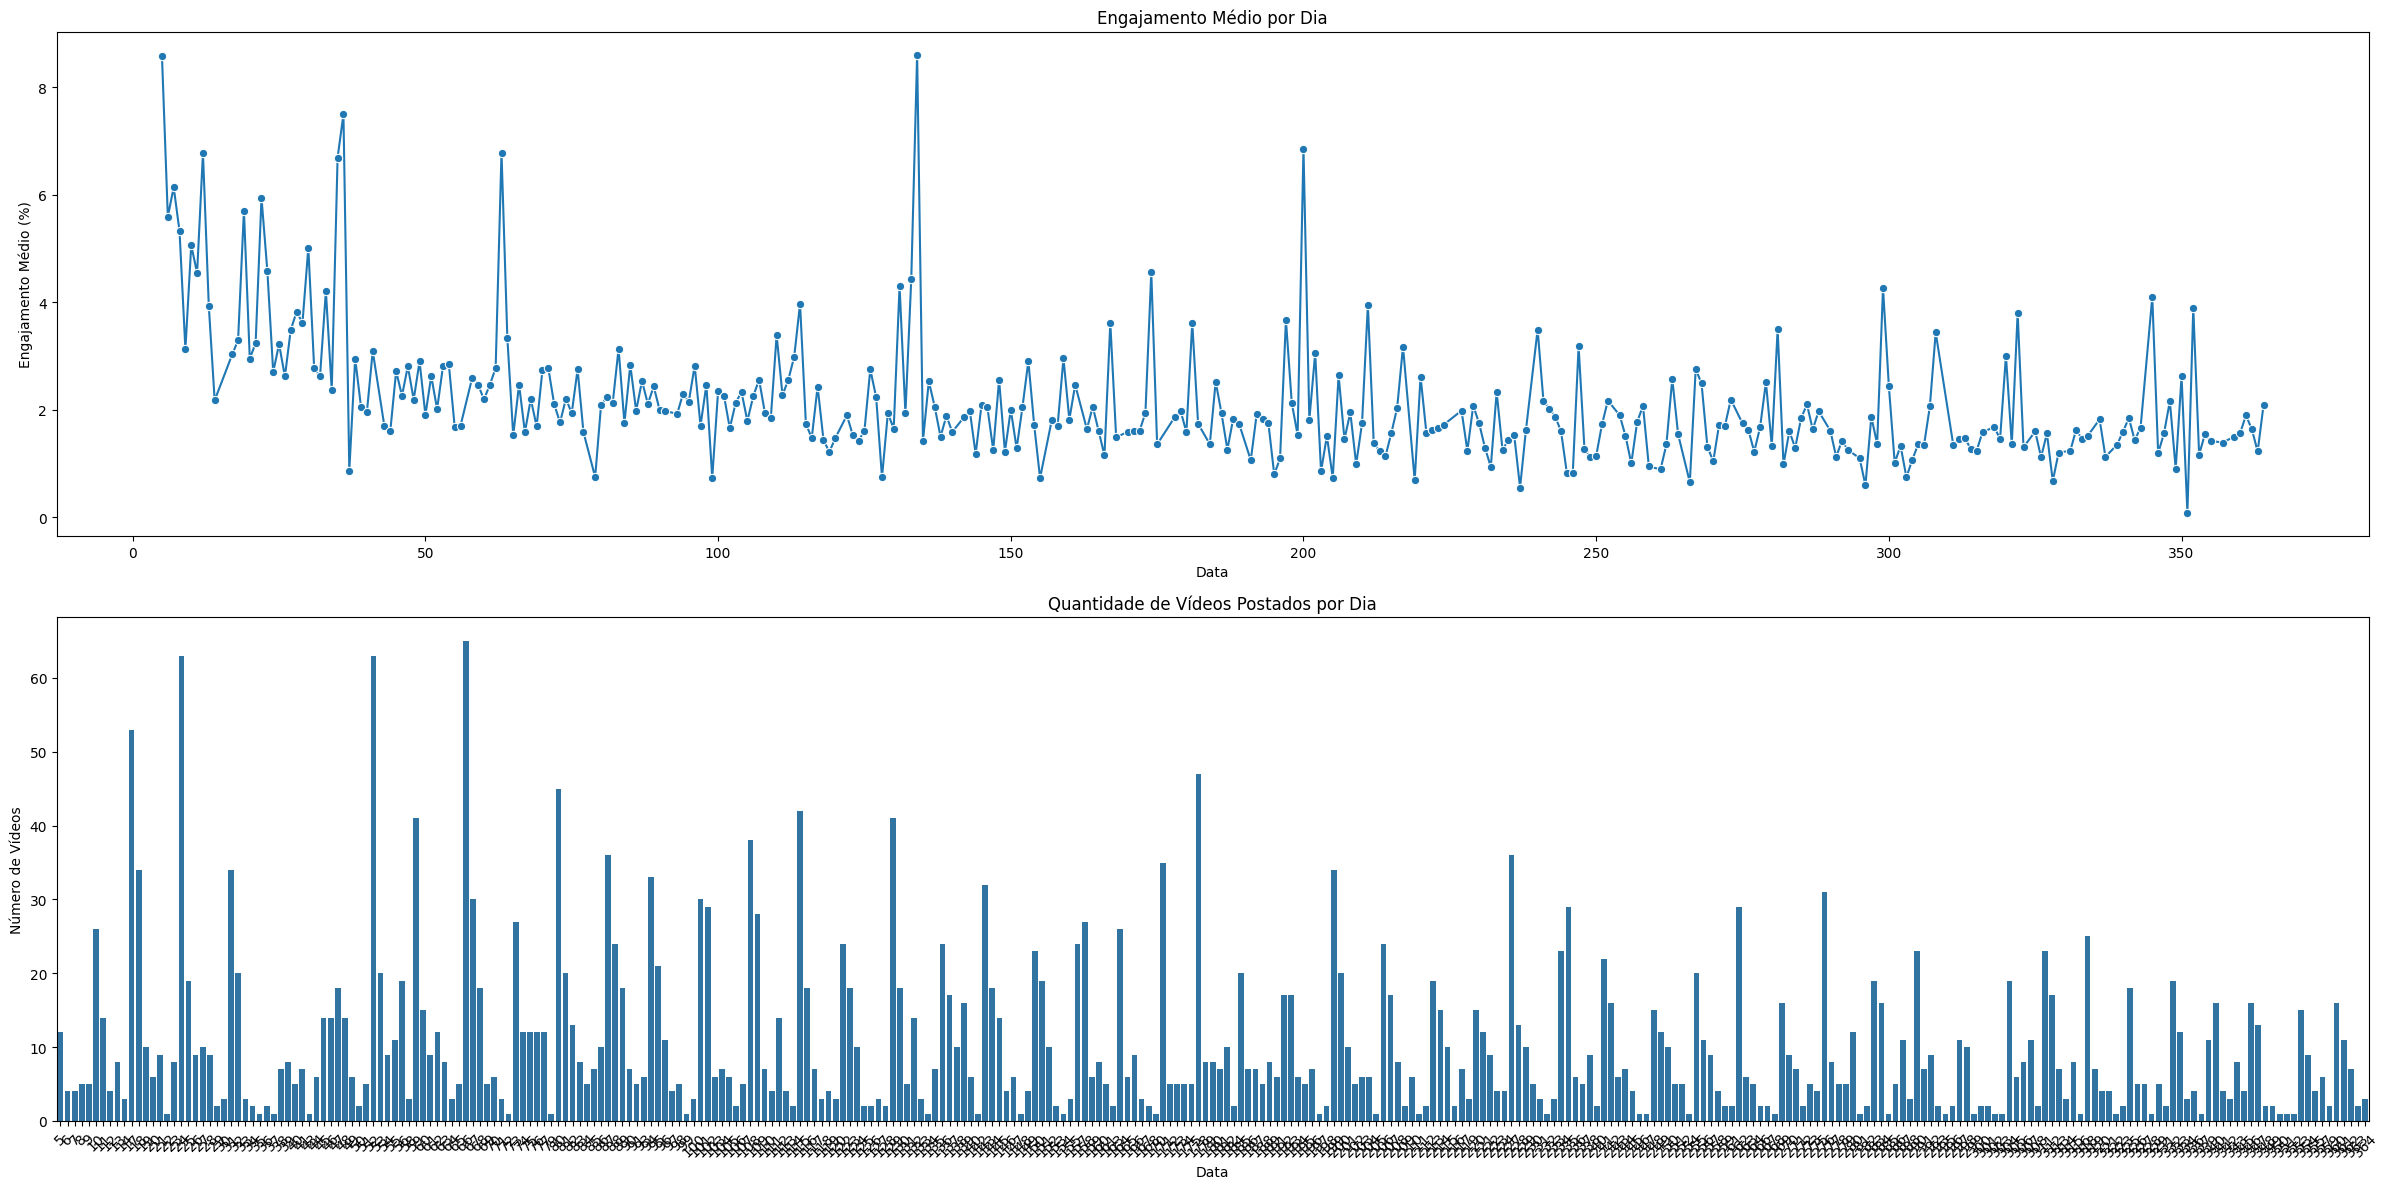

In [49]:
df_grouped = youtube_365_df.groupby('dias_na_plataforma').agg(
    engagement_mean=('engagement_rate', 'mean'), 
    video_count=('Views', 'count')  # Contando vídeos por dia
).reset_index()
fig, ax1 = plt.subplots(2, 1, figsize=(24, 12))

# Gráfico 1: Engajamento médio por dia
sns.lineplot(data=df_grouped, x='dias_na_plataforma', y='engagement_mean', marker='o', ax=ax1[0])
ax1[0].set_title('Engajamento Médio por Dia')
ax1[0].set_ylabel('Engajamento Médio (%)')
ax1[0].set_xlabel('Data')

# Gráfico 2: Quantidade de vídeos por dia
sns.barplot(data=df_grouped, x='dias_na_plataforma', y='video_count', ax=ax1[1])
ax1[1].set_title('Quantidade de Vídeos Postados por Dia')
ax1[1].set_ylabel('Número de Vídeos')
ax1[1].set_xlabel('Data')

# Ajustar layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

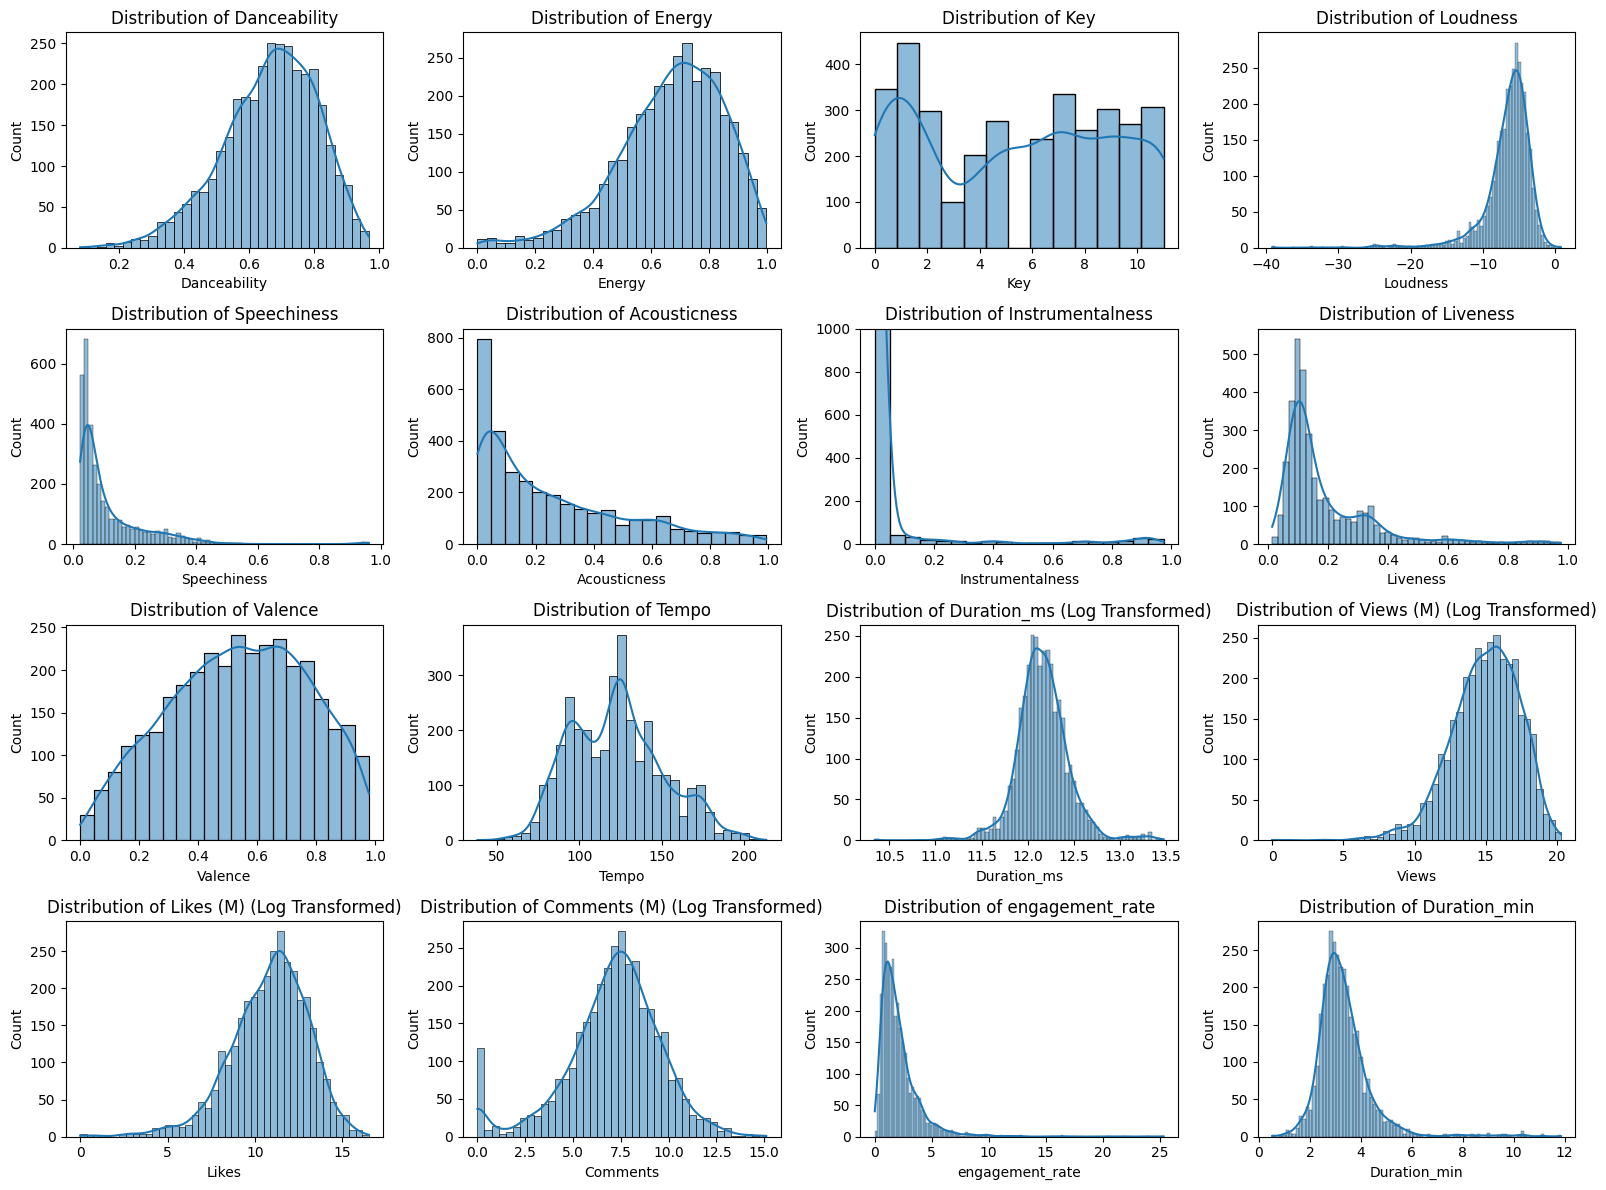

In [50]:
def get_scale_title(col_data, col_name):
    max_val = col_data.max()
    if max_val >= 1e9:
        scale = " (B)"
    elif max_val >= 1e6:
        scale = " (M)"
    else:
        scale = ""
    return f"{col_name}{scale}"

df_numeric = youtube_365_df.select_dtypes(include = ["float64"])


df_log = df_numeric.apply(lambda x: np.log1p(x) if x.max() > 1e5 else x)


plt.figure(figsize = (16, 12))
for i, col in enumerate(df_log, 1):
    plt.subplot(4, 4, i)
    
    
    if col == "Instrumentalness":
        sns.histplot(youtube_365_df[col], kde = True, binwidth = 0.05)
        plt.ylim(0, 1000)
    else:
        sns.histplot(df_log[col], kde = True)
    
    
    title = get_scale_title(df_numeric[col], col)
    plt.title(f"Distribution of {title} (Log Transformed)" if df_numeric[col].max() > 1e5 else f"Distribution of {col}")
    plt.xlabel(col)
    
plt.tight_layout()
plt.show()

Total number of outliers in column Duration_min: 149
Lower limit: 1.2404833333333327, Upper limit: 5.204350000000001
-----------------------------------------------------------
Total number of outliers in column Likes: 401
Lower limit: -316699.0, Upper limit: 564633.0
-----------------------------------------------------------
Total number of outliers in column Views: 420
Lower limit: -26650267.25, Upper limit: 46384164.75
-----------------------------------------------------------
Total number of outliers in column Tempo: 9
Lower limit: 39.976, Upper limit: 200.024
-----------------------------------------------------------
Total number of outliers in column Comments: 472
Lower limit: -7665.0, Upper limit: 13703.0
-----------------------------------------------------------
Total number of outliers in column engagement_rate: 180
Lower limit: -1.428944673230589, Upper limit: 5.0470191378410085
-----------------------------------------------------------


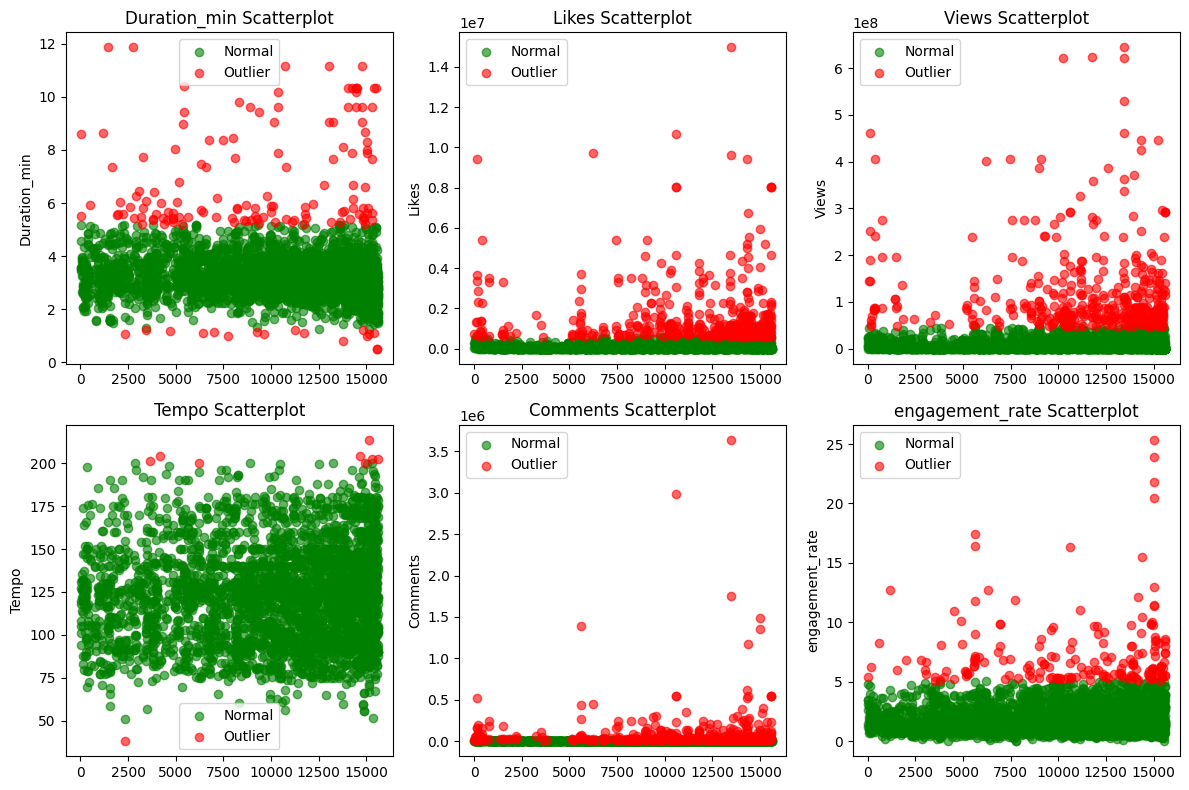

In [51]:

def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


columns_to_check = ["Duration_min", "Likes", "Views", "Tempo","Comments","engagement_rate"]


plt.figure(figsize = (12, 8))
for i, col in enumerate(columns_to_check, 1):

    outliers, lower, upper = find_outliers_iqr(youtube_365_df, col)

   
    normal_values = youtube_365_df[(youtube_365_df[col] >= lower) & (youtube_365_df[col] <= upper)]

    
    plt.subplot(2, 3, i)
    plt.scatter(normal_values.index, normal_values[col], label = "Normal", alpha = 0.6, c = "green")
    plt.scatter(outliers.index, outliers[col], label = "Outlier", alpha=0.6, c = "red")
    plt.title(f"{col} Scatterplot")
    plt.ylabel(col)
    plt.legend()

    
    print(f"Total number of outliers in column {col}: {len(outliers)}")
    print(f"Lower limit: {lower}, Upper limit: {upper}")
    print("-" * 59)

plt.tight_layout()
plt.show()

C:\Users\Samsung\AppData\Local\Temp\ipykernel_12700\1438477734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_365_df["Energy_group"] = pd.cut(youtube_365_df["Energy"], bins = energy_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"])
C:\Users\Samsung\AppData\Local\Temp\ipykernel_12700\1438477734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_365_df["Valence_group"] = pd.cut(youtube_365_df["Valence"], bins = valence_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6

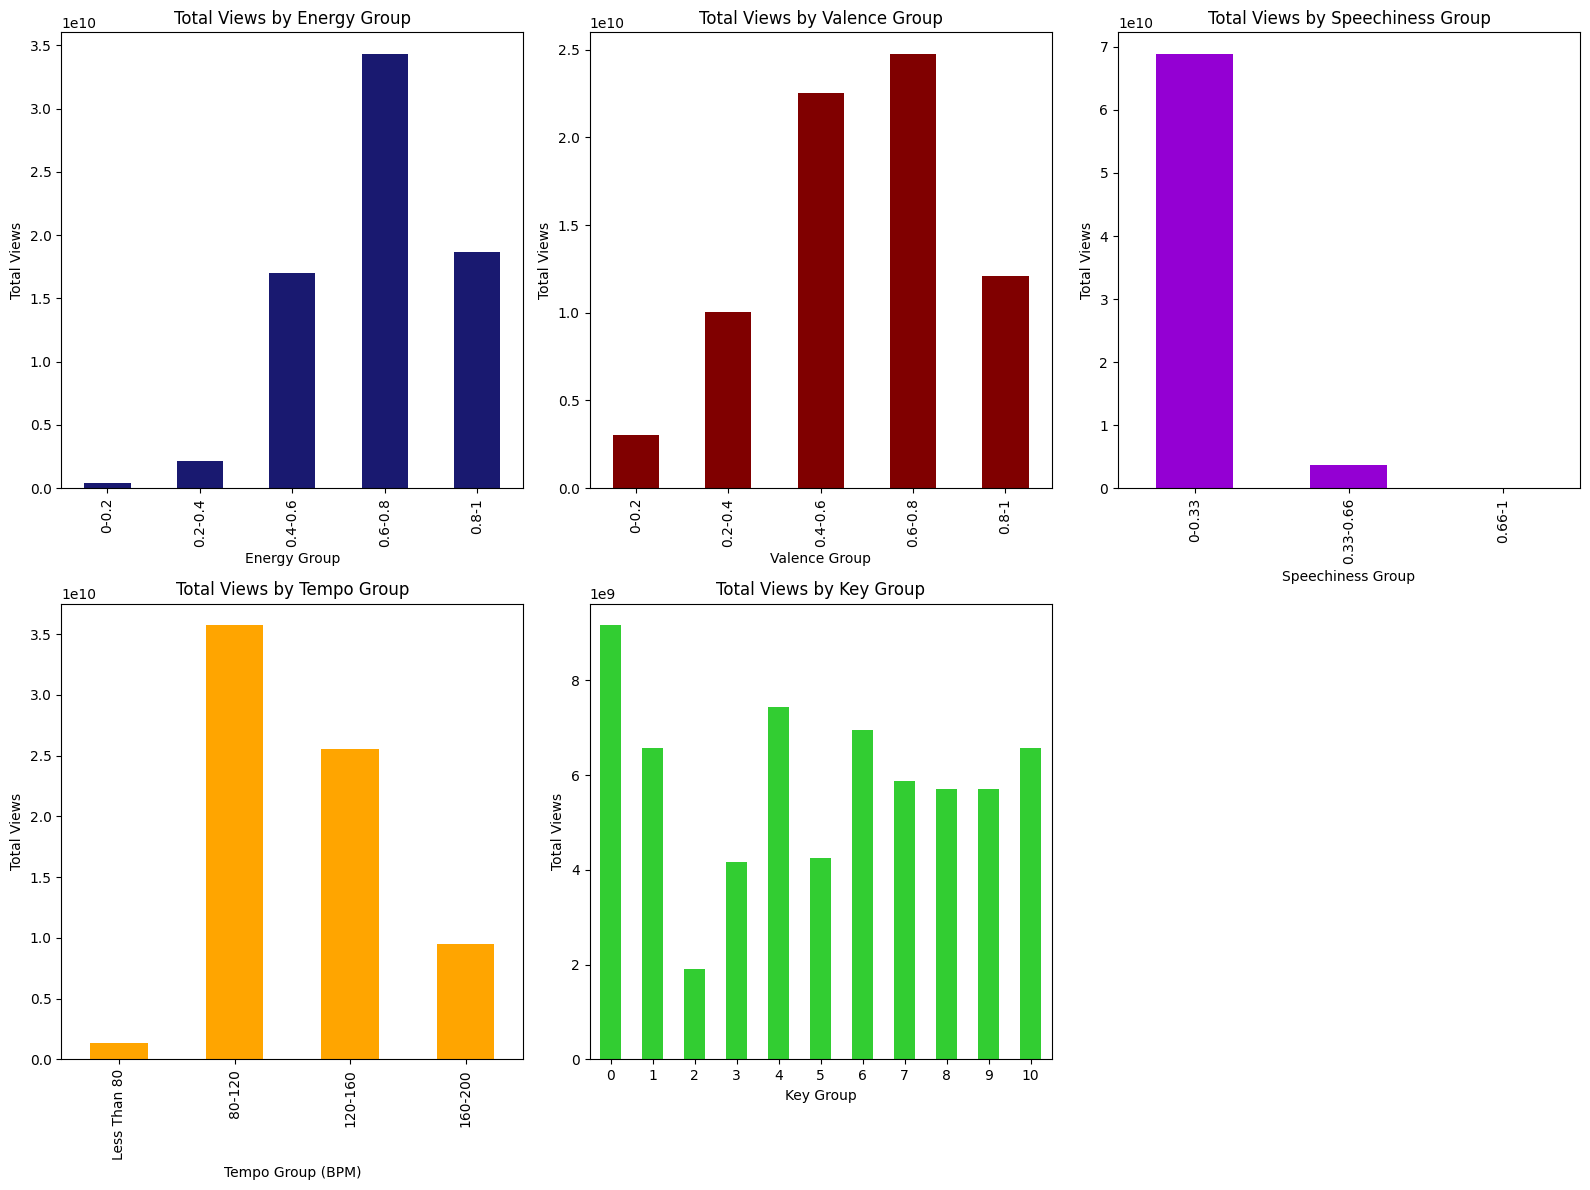

In [52]:
energy_bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
valence_bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
speechiness_bins = [0, 0.33, 0.66, 1]
tempo_bins = [0, 80, 120, 160, 200]

# Grouping the features into bins
youtube_365_df["Energy_group"] = pd.cut(youtube_365_df["Energy"], bins = energy_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"])
youtube_365_df["Valence_group"] = pd.cut(youtube_365_df["Valence"], bins = valence_bins, labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"])
youtube_365_df["Speechiness_group"] = pd.cut(youtube_365_df["Speechiness"], bins = speechiness_bins, labels = ["0-0.33", "0.33-0.66", "0.66-1"])
youtube_365_df["Tempo_group"] = pd.cut(youtube_365_df["Tempo"], bins = tempo_bins, labels = ["Less Than 80", "80-120", "120-160", "160-200"])
youtube_365_df["Key_group"] = pd.cut(youtube_365_df["Key"], bins = range(0, 12), labels = [f"{i}" for i in range(11)])

# Now that we have done the grouping, let's start visualization
plt.figure(figsize = (16, 12))

# Energy
plt.subplot(2, 3, 1)
youtube_365_df.groupby("Energy_group")["Views"].sum().plot(kind = "bar", color = "midnightblue")
plt.title("Total Views by Energy Group")
plt.xlabel("Energy Group")
plt.ylabel("Total Views")

# Valence
plt.subplot(2, 3, 2)
youtube_365_df.groupby("Valence_group")["Views"].sum().plot(kind = "bar", color = "maroon")
plt.title("Total Views by Valence Group")
plt.xlabel("Valence Group")
plt.ylabel("Total Views")

# Speechiness
plt.subplot(2, 3, 3)
youtube_365_df.groupby("Speechiness_group")["Views"].sum().plot(kind = "bar", color = "darkviolet")
plt.title("Total Views by Speechiness Group")
plt.xlabel("Speechiness Group")
plt.ylabel("Total Views")

# Tempo
plt.subplot(2, 3, 4)
youtube_365_df.groupby("Tempo_group")["Views"].sum().plot(kind = "bar", color = "orange")
plt.title("Total Views by Tempo Group")
plt.xlabel("Tempo Group (BPM)")
plt.ylabel("Total Views")

# Key
plt.subplot(2, 3, 5)
youtube_365_df.groupby("Key_group")["Views"].sum().plot(kind = "bar", color = "limegreen")
plt.title("Total Views by Key Group")
plt.xlabel("Key Group")
plt.ylabel("Total Views")
plt.xticks(rotation = 0)

plt.tight_layout()
plt.show()

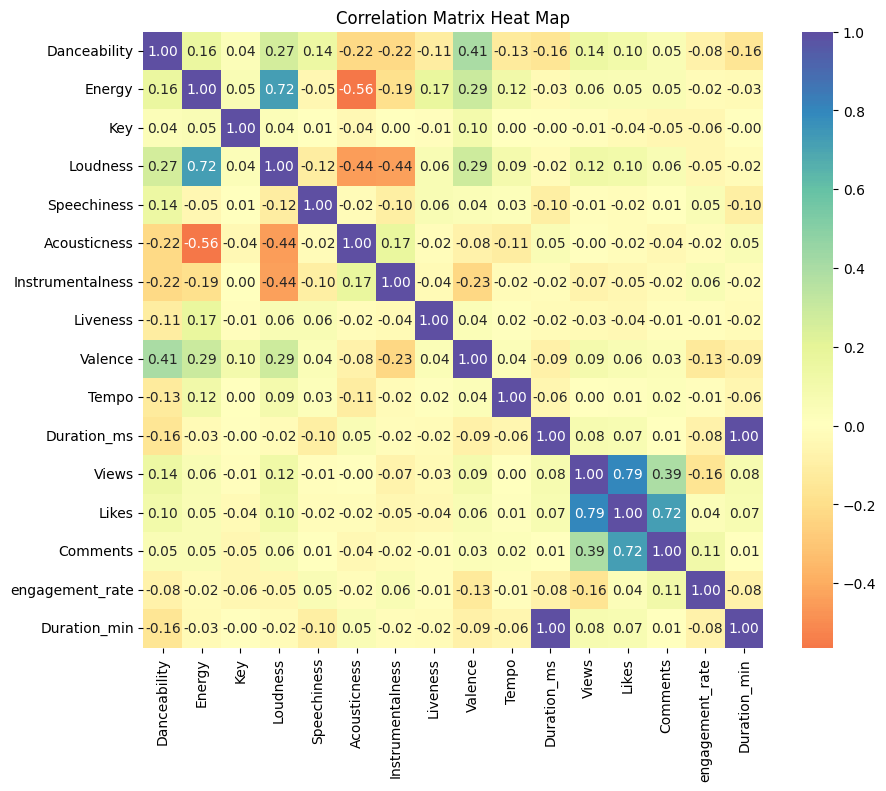

In [53]:
corr_matrix = df_numeric.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = "Spectral", center = 0, fmt = ".2f")
plt.title("Correlation Matrix Heat Map")
plt.show()

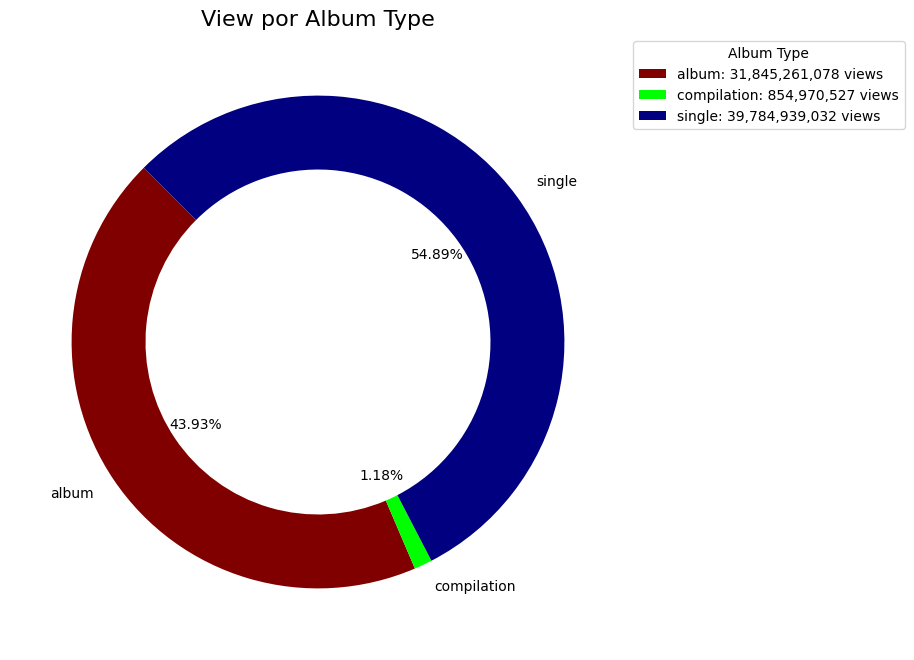

In [54]:
album_views = youtube_365_df.groupby("Album_type")["Views"].sum()

# Now let's create the Donut Chart.
plt.figure(figsize = (8, 8))

plt.pie(album_views, labels = album_views.index, autopct = "%1.2f%%", startangle = 135, colors = ["maroon", "lime", "navy"], wedgeprops = dict(width = 0.3))
plt.title("View por Album Type", fontsize = 16)
plt.legend(labels = [f"{label}: {value:,.0f} views" for label, value in zip(album_views.index, album_views)],
           title = "Album Type", loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1))

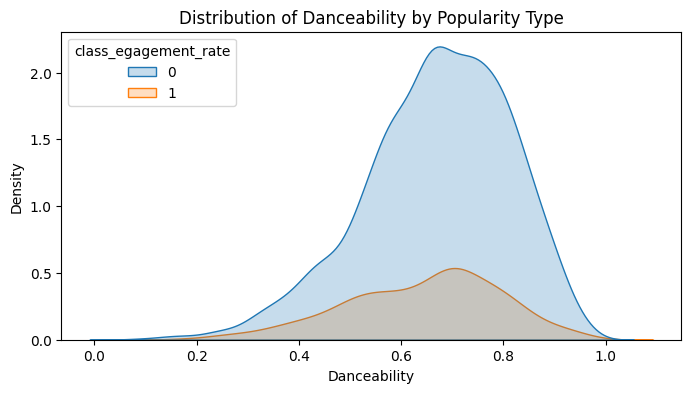

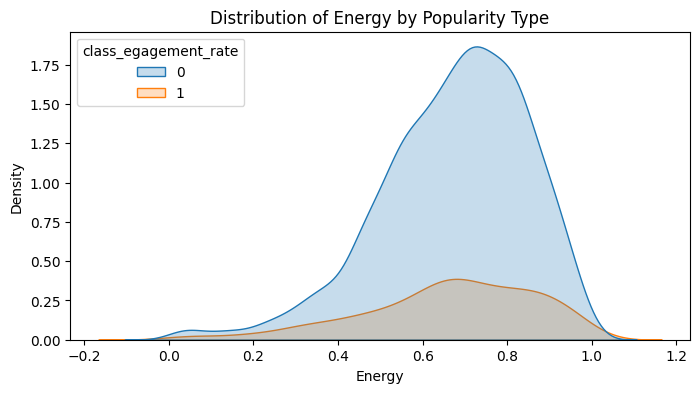

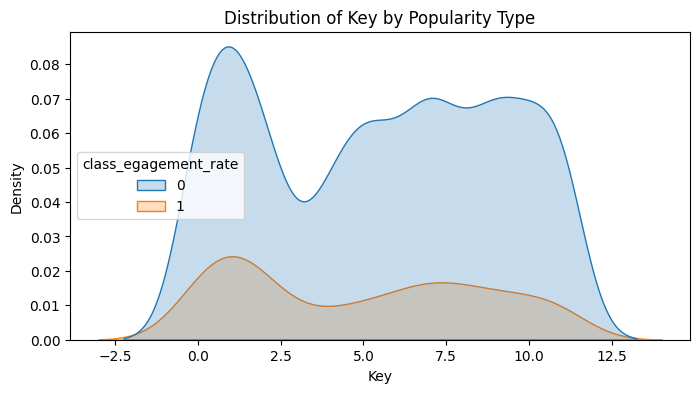

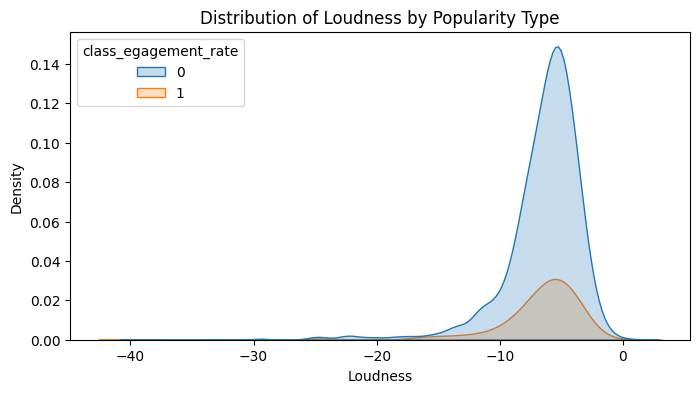

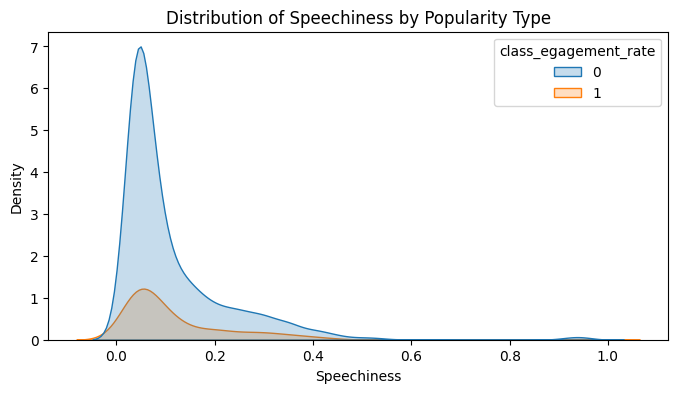

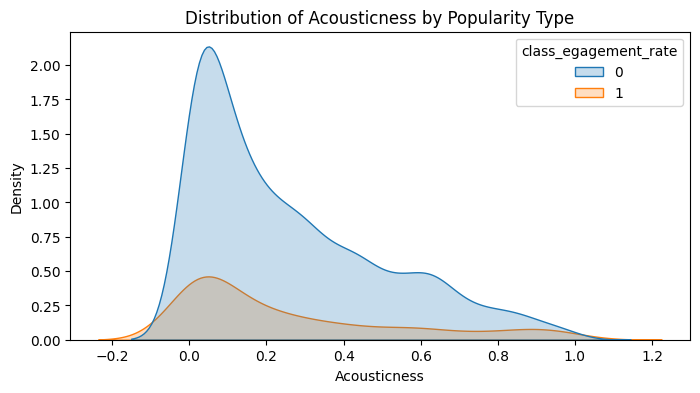

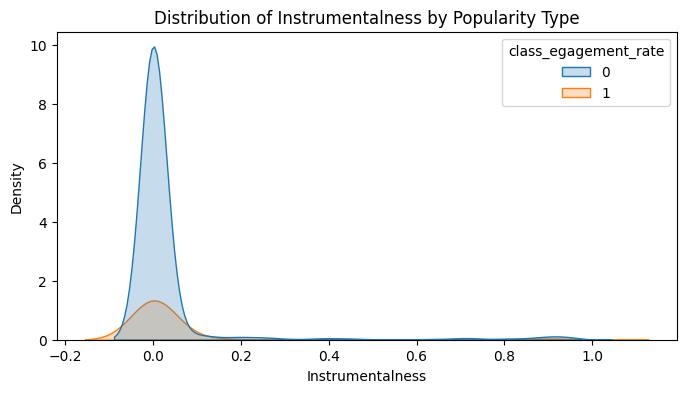

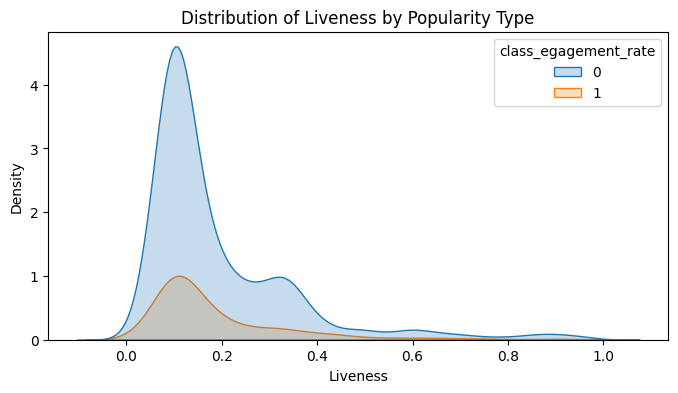

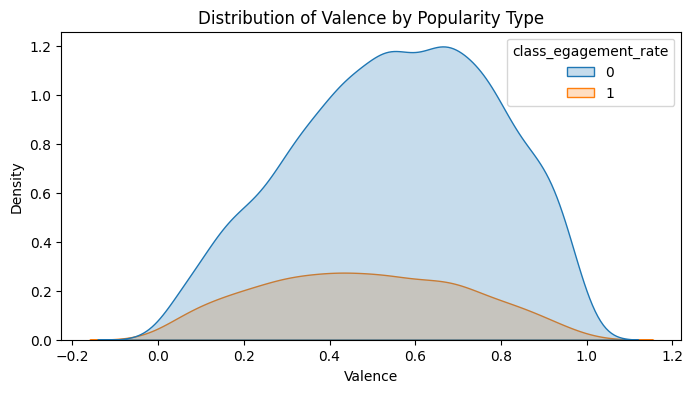

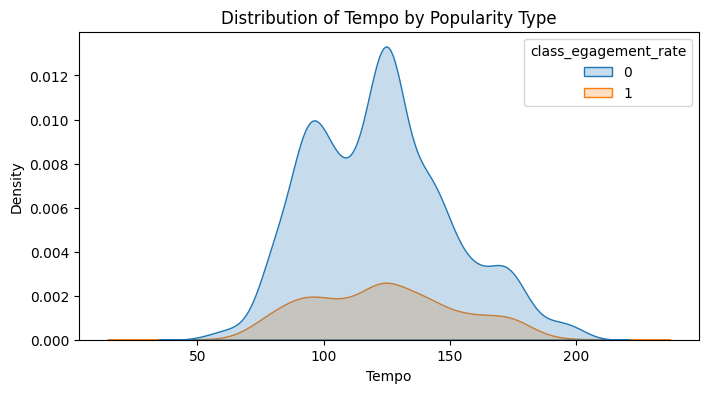

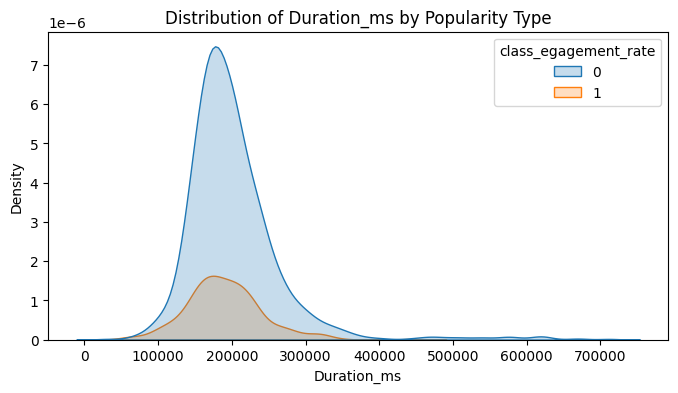

In [60]:
audio_features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness','Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo','Duration_ms']
for feature in audio_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=youtube_365_df, x=feature, hue='class_egagement_rate', fill=True)
    plt.title(f'Distribution of {feature} by Popularity Type')
    plt.show()

## Limpeza do df

In [63]:
youtube_365_df = pd.get_dummies(youtube_365_df, columns=["Album_type"], dtype=int)

In [64]:
youtube_365_df['artist_number'] = youtube_365_df['Artist'].str.split(',').str.len()

In [65]:
columns_drop=['index', 'Artist', 'Track', 'Album','Url_youtube', 'Title', 'Channel','Description', 'upload_date','Duration_min','Views', 'Likes', 'Comments']
youtube_365_clean=youtube_365_df.drop(columns=columns_drop)


In [66]:
col = 'engagement_rate'  
youtube_365_clean = youtube_365_clean[[c for c in youtube_365_clean if c != col] + [col]]

In [68]:
youtube_365_clean.to_csv("Youtube_365_df.csv", index=False)  
